In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score,recall_score, f1_score, confusion_matrix,roc_auc_score,roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten,Dense,LSTM,TimeDistributed,Input,Dropout
from tensorflow.keras.models import Model 

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Assignment 2 - Practical Deep Learning Workshop

Peleg Biton 203842703
Asaf Zaks 302329693
Omer Nagar 307937714

## Part 1







###a. Data Set details -

The "PAMAP2 Physical Activity Monitoring Data Set" contains data of 18 different physical activities (such as walking, cycling, playing soccer, etc.), performed by 9 subjects wearing 3 inertial measurement units and a heart rate monitor.
Each activity is either protocol or optional.

The dataset contains protocol activities data-file for each of the subjects,
and optional activities data-file for each subject who preformed at least one optional activity.

Data features as explained in the database ReadMe file - <br> 
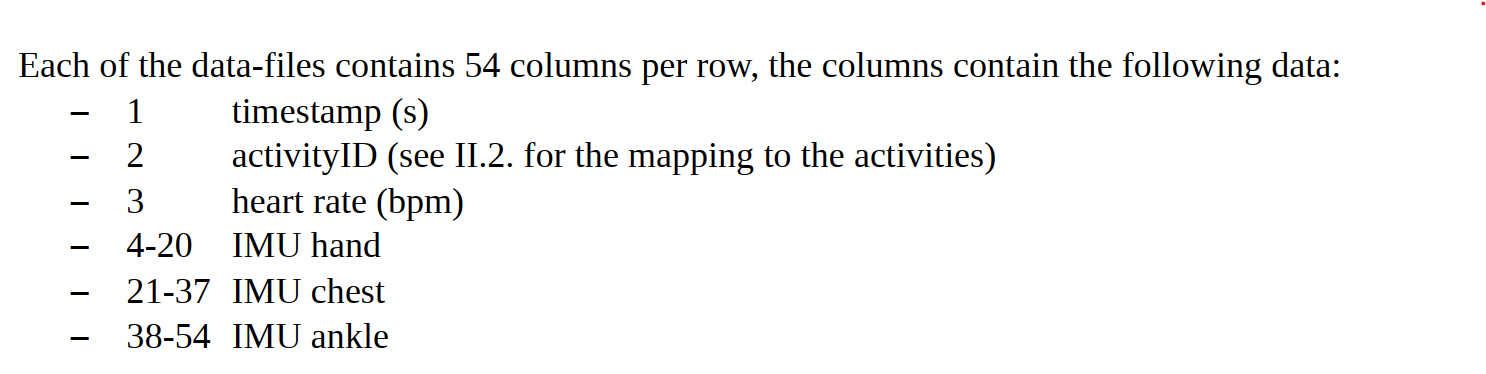

In [5]:
Features = [
    'timestamp',
    'activity_ID',
    'heart_rate',    
    'hand_temperature',
    'hand_acc_16_x','hand_acc_16_y','hand_acc_16_z',
    'hand_acc_6_x','hand_acc_6_y','hand_acc_6_z',
    'hand_gyro_x','hand_gyro_y','hand_gyro_z',
    'hand_magnet_x','hand_magnet_y','hand_magnet_z',
    'hand_orientation_1','hand_orientation_2','hand_orientation_3','hand_orientation_4',
    'chest_temperature',
    'chest_acc_16_x','chest_acc_16_y','chest_acc_16_z',
    'chest_acc_6_x','chest_acc_6_y','chest_acc_6_z',
    'chest_gyro_x','chest_gyro_y','chest_gyro_z',
    'chest_magnet_x','chest_magnet_y','chest_magnet_z',
    'chest_orientation_1','chest_orientation_2','chest_orientation_3','chest_orientation_4',
	'ankle_temperature',
    'ankle_acc_16_x','ankle_acc_16_y','ankle_acc_16_z',
    'ankle_acc_6_x','ankle_acc_6_y','ankle_acc_6_z',
    'ankle_gyro_x','ankle_gyro_y','ankle_gyro_z',
    'ankle_magnet_x','ankle_magnet_y','ankle_magnet_z',
    'ankle_orientation_1','ankle_orientation_2','ankle_orientation_3','ankle_orientation_4'
]

First, We will upload all the data (including test) to get a better understaning of it & pre-process.<br>
We will add a 'subject' column for more detailed analysis, and 'set' column (Protocol or Optional) for later validation work.

In [6]:
allData = pd.DataFrame()
for subject in range(101,110):
    x = pd.read_csv(r'/content/drive/MyDrive/PAMAP2_Dataset/Protocol/subject'+ str(subject) + '.dat',sep=' ',names = Features)
    x['subject'] = str(subject)
    x['set'] = 'Protocol'
    allData= allData.append(x)
for subject in ['101','105','106','108','109']:
    x = pd.read_csv(r'/content/drive/MyDrive/PAMAP2_Dataset/Optional/subject'+ subject + '.dat',sep=' ',names = Features)
    x['subject'] = subject
    x['set'] = 'Optional'
    allData= allData.append(x)


In [7]:
allData.set_index('timestamp',inplace=True)
allData.head()

,activity_ID,heart_rate,hand_temperature,hand_acc_16_x,hand_acc_16_y,hand_acc_16_z,hand_acc_6_x,hand_acc_6_y,hand_acc_6_z,hand_gyro_x,hand_gyro_y,hand_gyro_z,hand_magnet_x,hand_magnet_y,hand_magnet_z,hand_orientation_1,hand_orientation_2,hand_orientation_3,hand_orientation_4,chest_temperature,chest_acc_16_x,chest_acc_16_y,chest_acc_16_z,chest_acc_6_x,chest_acc_6_y,chest_acc_6_z,chest_gyro_x,chest_gyro_y,chest_gyro_z,chest_magnet_x,chest_magnet_y,chest_magnet_z,chest_orientation_1,chest_orientation_2,chest_orientation_3,chest_orientation_4,ankle_temperature,ankle_acc_16_x,ankle_acc_16_y,ankle_acc_16_z,ankle_acc_6_x,ankle_acc_6_y,ankle_acc_6_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_magnet_x,ankle_magnet_y,ankle_magnet_z,ankle_orientation_1,ankle_orientation_2,ankle_orientation_3,ankle_orientation_4,subject,set
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,-0.092217,0.056812,-0.015845,14.6806,-69.2128,-5.58905,1.0,0.0,0.0,0.0,31.8125,0.238080,9.80003,-1.68896,0.265304,9.81549,-1.41344,-0.005065,-0.006781,-0.005663,0.471960,-51.0499,43.2903,1.0,0.0,0.0,0.0,30.3125,9.65918,-1.65569,-0.099797,9.64689,-1.55576,0.310404,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,101,Protocol
8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,-0.024413,0.047758,0.006474,14.8991,-69.2224,-5.82311,1.0,0.0,0.0,0.0,31.8125,0.319530,9.61282,-1.49328,0.234939,9.78539,-1.42846,0.013685,0.001486,-0.041522,1.016900,-50.3966,43.1768,1.0,0.0,0.0,0.0,30.3125,9.69370,-1.57902,-0.215687,9.61670,-1.61630,0.280488,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,101,Protocol
8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,-0.057976,0.032574,-0.006988,14.2420,-69.5197,-5.12442,1.0,0.0,0.0,0.0,31.8125,0.235593,9.72421,-1.76621,0.173850,9.72528,-1.51894,-0.039923,0.034056,-0.002113,0.383136,-51.8336,43.7782,1.0,0.0,0.0,0.0,30.3125,9.58944,-1.73276,0.092914,9.63173,-1.58605,0.280311,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,101,Protocol
8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,-0.002352,0.032810,-0.003747,14.8908,-69.5439,-6.17367,1.0,0.0,0.0,0.0,31.8125,0.388697,9.53572,-1.72410,0.157969,9.64994,-1.57952,0.007513,-0.010498,-0.020684,0.315400,-49.8144,43.1670,1.0,0.0,0.0,0.0,30.3125,9.58814,-1.77040,0.054545,9.63197,-1.63135,0.340997,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,101,Protocol
8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,0.012269,0.018305,-0.053325,15.5612,-68.8196,-6.28927,1.0,0.0,0.0,0.0,31.8125,0.315800,9.49908,-1.60914,0.233506,9.57411,-1.44418,-0.003822,-0.011217,-0.025975,-0.297733,-51.8097,43.6453,1.0,0.0,0.0,0.0,30.3125,9.69771,-1.65625,-0.060809,9.64699,-1.64647,0.340965,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,101,Protocol


In [ ]:
allData.shape , allData[~allData['subject'].isin(['107','108'])].shape

((3850505, 55), (2948463, 55))

The whole dataset cantains a total of 3,850,505 records. <br>
Leaving the two test subject aside, we got 2,948,463 for training and validation. <br>

The database ReadMe file instruct us that data labeled with activityID = 0 should be discarded in any kind of analysis. <br>
It also tells us that the IMU's orientation data is invalid. <br>
As part of our data-preperation we will drop both- 

In [8]:
def CleanActivityZero(data_frame):
    return data_frame[data_frame['activity_ID'] != 0] 

In [9]:
def DropOrientation(data_frame):
    return data_frame.loc[:,~data_frame.columns.str.contains('orientation')]

In [10]:
allData = CleanActivityZero(allData)
allData.shape , allData[~allData['subject'].isin(['107','108'])].shape

((2724953, 55), (2077883, 55))

In [11]:
allData = DropOrientation(allData)
allData.shape , allData[~allData['subject'].isin(['107','108'])].shape

((2724953, 43), (2077883, 43))

After cleaning - <br>
We left with total of 2,724,953 records. <br>
Leaving the two test subject aside, we got 2,077,883 left for training and validation. <br>

Next we will look on nan values -

In [ ]:
allData.isna().sum()

activity_ID                0
heart_rate           2476126
hand_temperature       11868
hand_acc_16_x          11868
hand_acc_16_y          11868
hand_acc_16_z          11868
hand_acc_6_x           11868
hand_acc_6_y           11868
hand_acc_6_z           11868
hand_gyro_x            11868
hand_gyro_y            11868
hand_gyro_z            11868
hand_magnet_x          11868
hand_magnet_y          11868
hand_magnet_z          11868
chest_temperature       3058
chest_acc_16_x          3058
chest_acc_16_y          3058
chest_acc_16_z          3058
chest_acc_6_x           3058
chest_acc_6_y           3058
chest_acc_6_z           3058
chest_gyro_x            3058
chest_gyro_y            3058
chest_gyro_z            3058
chest_magnet_x          3058
chest_magnet_y          3058
chest_magnet_z          3058
ankle_temperature       9867
ankle_acc_16_x          9867
ankle_acc_16_y          9867
ankle_acc_16_z          9867
ankle_acc_6_x           9867
ankle_acc_6_y           9867
ankle_acc_6_z 

As we can see each of the sensors has nan values, resulting gaps between Time series data. <br>
Many of those gaps are result of montiors smapling errors. <br>
We learn from the Readme file that heart rate monitor has the most nan value due to different sampling frequency. <br>
We can easily see that just by looking on a short sequence of the first subject data -

In [ ]:
plotdata = allData[(allData['subject'] =='101') & (allData['set'] == 'Protocol')]

<function matplotlib.pyplot.show>

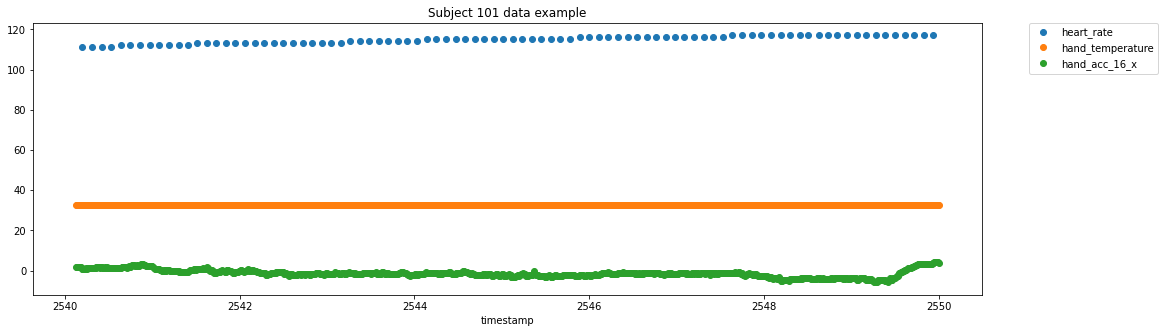

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(plotdata[[ 'heart_rate']][2540:2550],'o',label = 'heart_rate')
plt.plot(plotdata[[ 'hand_temperature']][2540:2550],'o',label = 'hand_temperature')
plt.plot(plotdata[[ 'hand_acc_16_x']][2540:2550],'o',label = 'hand_acc_16_x')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('timestamp')
plt.title('Subject 101 data example')
plt.show

We will try and interpulate the data based on the subject - 

In [12]:
def interpulate(data):
    interpulatedData = data.copy()
    for col in interpulatedData.columns:
        interpulatedData[col] = interpulatedData[col].interpolate(method='values').ffill().bfill()
    return interpulatedData

<function matplotlib.pyplot.show>

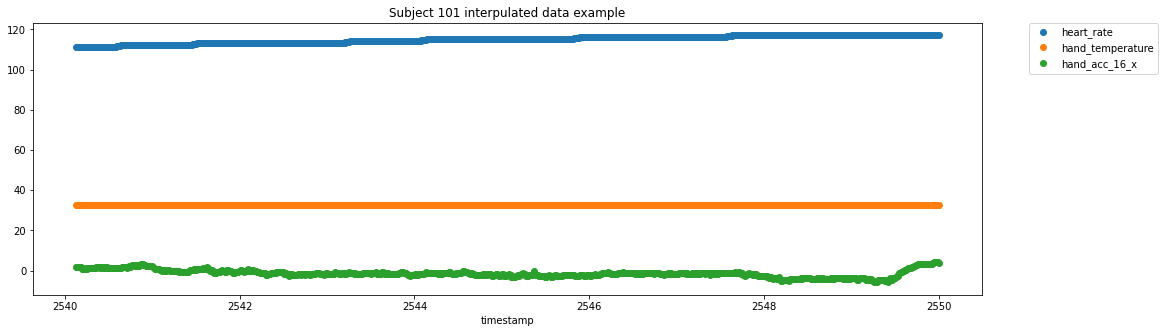

In [ ]:
intplotdata = interpulate(plotdata)
plt.figure(figsize=(17,5))
plt.plot(intplotdata[[ 'heart_rate']][2500:2550],'o',label = 'heart_rate')
plt.plot(intplotdata[[ 'hand_temperature']][2500:2550],'o',label = 'hand_temperature')
plt.plot(intplotdata[[ 'hand_acc_16_x']][2500:2550],'o',label = 'hand_acc_16_x')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('timestamp')
plt.title('Subject 101 interpulated data example')
plt.show

As we can see the interpulation function kept the original trend line and filled the gaps. We will preform the same interpulation on each of the subjects and sets individually- 

In [13]:
interpulatedData = pd.DataFrame()
subjects = allData.subject.unique()
sets = allData.set.unique()
for sub in subjects:
    for curSet in sets:
        temp = (allData[(allData['subject'] == sub ) & (allData['set'] == curSet)]).copy()        
        if(~temp.empty):
            interpulatedData = interpulatedData.append(interpulate(temp))
interpulatedData.shape , interpulatedData[~interpulatedData['subject'].isin(['107','108'])].shape


((2724953, 43), (2077883, 43))

In [ ]:
interpulatedData.isna().sum()

activity_ID          0
heart_rate           0
hand_temperature     0
hand_acc_16_x        0
hand_acc_16_y        0
hand_acc_16_z        0
hand_acc_6_x         0
hand_acc_6_y         0
hand_acc_6_z         0
hand_gyro_x          0
hand_gyro_y          0
hand_gyro_z          0
hand_magnet_x        0
hand_magnet_y        0
hand_magnet_z        0
chest_temperature    0
chest_acc_16_x       0
chest_acc_16_y       0
chest_acc_16_z       0
chest_acc_6_x        0
chest_acc_6_y        0
chest_acc_6_z        0
chest_gyro_x         0
chest_gyro_y         0
chest_gyro_z         0
chest_magnet_x       0
chest_magnet_y       0
chest_magnet_z       0
ankle_temperature    0
ankle_acc_16_x       0
ankle_acc_16_y       0
ankle_acc_16_z       0
ankle_acc_6_x        0
ankle_acc_6_y        0
ankle_acc_6_z        0
ankle_gyro_x         0
ankle_gyro_y         0
ankle_gyro_z         0
ankle_magnet_x       0
ankle_magnet_y       0
ankle_magnet_z       0
subject              0
set                  0
dtype: int6

No 'nan' values left.

###b. Data distribution graphs - 

The task is a classification task. <br> Given body parameters of a subject from 200 senquential time points while he perform 1 out of 18 activities - we will try and predict which activity was performed by him.

 First we want to see how the activities are distirbuted - 

    activity_ID       0
0             1  192523
1             2  185188
2             3  189931
3             4  238761
4             5   98199
5             6  164600
6             7  188107
7             9   83646
8            10  309935
9            11   54519
10           12  117216
11           13  104944
12           16  175353
13           17  238690
14           18   99878
15           19  187188
16           20   46915
17           24   49360


Text(0.5, 1.0, 'Activities distribution (All records)')

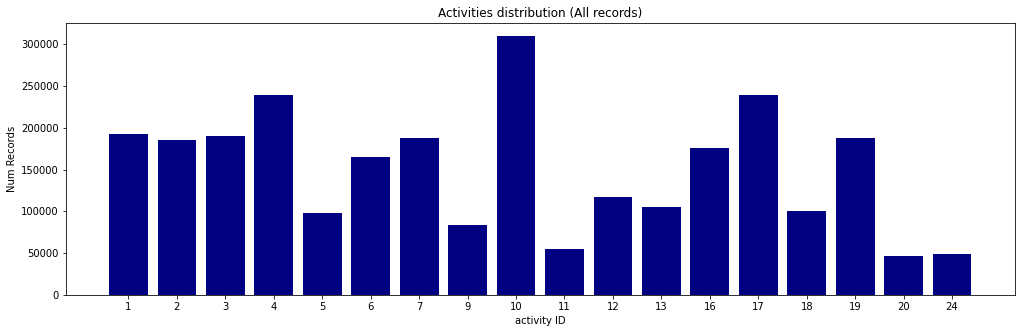

In [ ]:
groupBy = allData.groupby('activity_ID').size().reset_index()
print(groupBy)
difActivities = list(groupBy[0])
bins = range(len(difActivities))
f, ax = plt.subplots(figsize=(17,5))
plt.bar(bins, difActivities, color="navy")
ax.set_xticklabels(list(groupBy['activity_ID']))
ax.set_xticks(np.arange(len(bins)))
ax.set_ylabel('Num Records')
ax.set_xlabel('activity ID')
ax.set_title('Activities distribution (All records)')


As we can see the activities are not exactly disterbuted uniformly.<br> Activity 10 (computer work) has most records - 309,935, 6.6 times more then activity 20 (playing soccer) with only 46,915 records.

Now lets see how many records we have for each subject - 

  subject       0
0     101  469325
1     102  263349
2     103  174338
3     104  231421
4     105  411813
5     106  362373
6     107  232776
7     108  414294
8     109  165264


Text(0.5, 1.0, 'Subjects distribution (All records)')

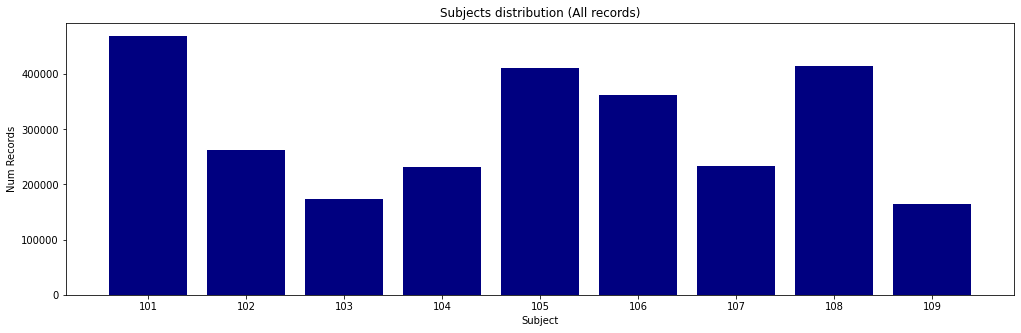

In [ ]:
groupBy = allData.groupby('subject').size().reset_index()
print(groupBy)
difActivities = list(groupBy[0])
bins = range(len(difActivities))
f, ax = plt.subplots(figsize=(17,5))
plt.bar(bins, difActivities, color="navy")
ax.set_xticklabels(list(groupBy['subject']))
ax.set_xticks(np.arange(len(bins)))
ax.set_ylabel('Num Records')
ax.set_xlabel('Subject')
ax.set_title('Subjects distribution (All records)')

Subject 101 with most records - 469,325 <br>
Subject 109 with least records - 165,264

We can also check which of the subject preformed each activity - 

Text(0.5, 0.98, 'Subject VS. Activity')

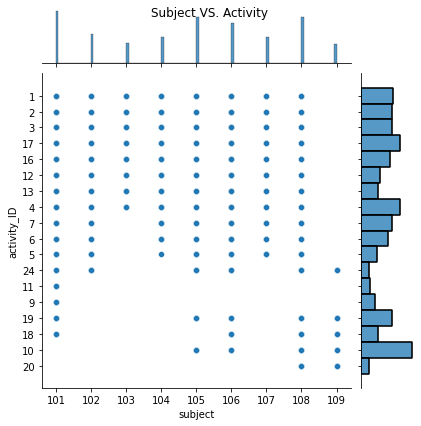

In [ ]:
graphdata = allData.copy()
graphdata.subject = pd.to_numeric(graphdata.subject, errors='ignore')
graphdata["activity_ID"] = graphdata["activity_ID"].astype(str)
p = sns.jointplot(data=graphdata, x="subject", y="activity_ID")
p.fig.suptitle("Subject VS. Activity")

Intersting thing to see is that we have train data for activities 9 and 11 even though our test isn't covering them. <br>
Also, all available activities are represented in the train data.

In [14]:
import gc; gc.enable()

In [15]:
del allData;
#del groupBy; 
#del plotdata;
gc.collect()

22

### c. Ideas for Self-supervised tasks -

1. Predict subject's acceleration based on time-series acceleration data.
2. Predict subject's hand temperature by his chest temperature.

## Part 2

###a. Validation strategy -


We decided to devide the data by subjects, and use a group validation strategy. <br>
The motivation to use subject based group validation is to keep our validation as similliar as possible to the test, <br>
as in the test we will use data of subjects the model wasn't trained with - we want the validation to be constructed by different subject then those on the train on each fold. <br>
Because we have only seven subjects to work with we will preform 'Leave one group out' validation. We won't use the folds where subjects 101 and 109 are validations because we saw earlier that both have unique activities other subjects havn't preformed (so we won't be able to predict those) leaving us with a reasonable amount of 5 folds.

In [16]:
validationSubjects = ['102','103','104','105','106']

### b. Naive Baseline -

Naive Time-series data preperation - <br>
We will create dictionary with each subject's data.<br>
First, we will break the data to subjects, then to activities. We will calculate moving avarage with window size = 200 on each  table containing at least 200 records. <br>
The dictinary named 'groups' will hold each subject's list of data frames - df for a sequence of records of single activity data.

In [17]:
def create_activity_bins(df):
    #df.set_index('timestamp',inplace=True)
    acivityList=list(df["activity_ID"])
    indexes =[0]+[index for index, _ in enumerate(acivityList) if acivityList[index] != acivityList[index-1]]
    indexes.append(len(acivityList))
    final = [df.iloc[indexes[i]:indexes[i+1]] for i, _ in enumerate(indexes) if i != len(indexes)-1]
    return final

In [ ]:
look_back = 200

In [ ]:
groups = {
    "101" : [],
    "102" : [],
    "103" : [],
    "104" : [],
    "105" : [],
    "106" : [],
    "107" : [],
    "108" : [],
    "109" : []
}
for subject in groups.keys():
    for curSet in ['Protocol','Optional']:
        temp = (interpulatedData[(interpulatedData['subject'] == subject ) & (interpulatedData['set'] == curSet)]).copy()
        if(~temp.empty):
            temp.drop('subject',axis=1, inplace = True)
            temp.drop('set',axis=1, inplace = True)
            bins = create_activity_bins(temp)
            for bin in bins:
                if ~bin.empty and bin.shape[0] >= look_back:
                    bin = bin.rolling(window=200).mean()
                    bin.dropna(inplace=True)
                    bin.activity_ID = bin.activity_ID.astype(int)
                    groups[subject] = groups[subject] + [bin]

In [ ]:
trainData = {
    "101" : groups["101"],
    "102" : groups["102"],
    "103" : groups["103"],
    "104" : groups["104"],
    "105" : groups["105"],
    "106" : groups["106"],
    "109" : groups["109"]
}
testData = {
    "107" : groups["107"],
    "108" : groups["108"]
}

In [ ]:
del groups;
gc.collect()

0

In order to create a naive baseline solution we will first try and use visualizations to find patterns in the data. <br>
   Good patterns will be later use as 'if' conditions on our solution - 

Below there are few combinations we tried - 

In [ ]:
graphdata = pd.DataFrame()
for subject in list(trainData.keys()):
    graphdata = graphdata.append(pd.concat(trainData[subject]))
graphdata["activity_ID"] = graphdata["activity_ID"].astype(str)
graphdata.reset_index(inplace=True)

Text(0.5, 0.98, 'chest_temperature VS. ankle_temperature')

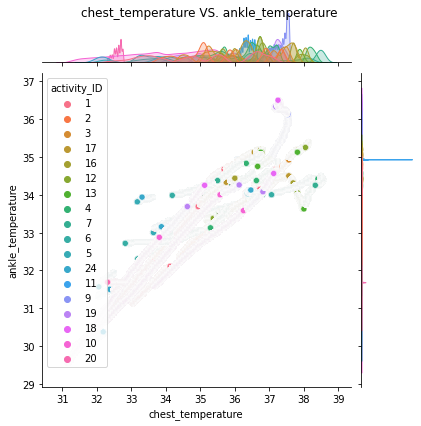

In [ ]:
p = sns.jointplot(data=graphdata, x="chest_temperature", y="ankle_temperature", hue="activity_ID")
p.fig.suptitle("chest_temperature VS. ankle_temperature")

Text(0.5, 0.98, 'ankle_acc_16_x VS. ankle_acc_16_y')

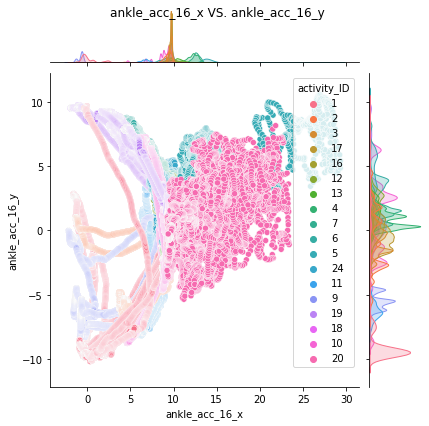

In [ ]:
p = sns.jointplot(data=graphdata, x="ankle_acc_16_x", y="ankle_acc_16_y", hue="activity_ID")
p.fig.suptitle("ankle_acc_16_x VS. ankle_acc_16_y")

Text(0.5, 0.98, 'hand_magnet_x VS. hand_magnet_y')

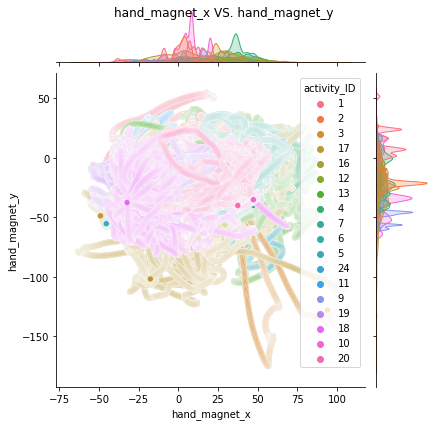

In [ ]:
p = sns.jointplot(data=graphdata, x="hand_magnet_x", y="hand_magnet_y", hue="activity_ID")
p.fig.suptitle("hand_magnet_x VS. hand_magnet_y")

Text(0.5, 0.98, 'hand_gyro_x VS. hand_gyro_y')

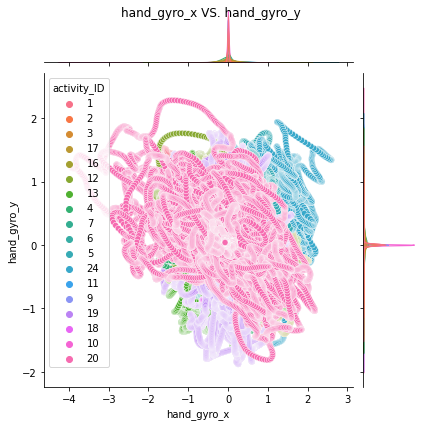

In [ ]:
p = sns.jointplot(data=graphdata, x="hand_gyro_x", y="hand_gyro_y", hue="activity_ID")
p.fig.suptitle("hand_gyro_x VS. hand_gyro_y")

Text(0.5, 0.98, 'hand_temperature VS. heart_rate')

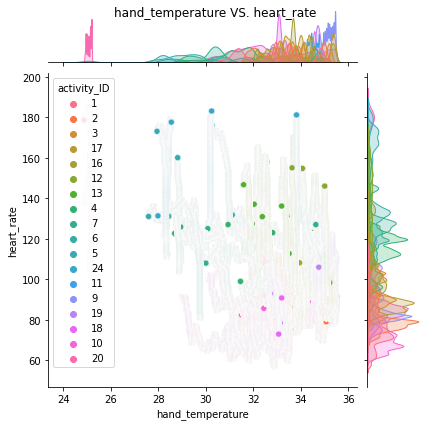

In [ ]:
p= sns.jointplot(data=graphdata, x="hand_temperature", y="heart_rate", hue="activity_ID")
p.fig.suptitle("hand_temperature VS. heart_rate")


Seeing the relativly high seperation on the last plot, we chose to use his features - heart_rate and hand_temperature, as our classifiers.<br>
We can also look only on each activity's mean values for those features to see the difference - 

Text(0.5, 0.98, 'hand_temperature VS. heart_rate (means)')

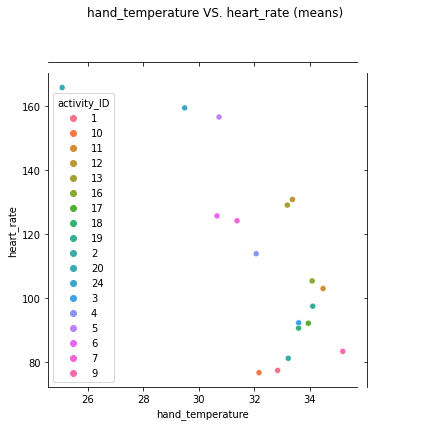

In [ ]:
means = graphdata[['activity_ID','hand_temperature','heart_rate']].groupby('activity_ID').mean().reset_index()
p= sns.jointplot(data=means, x="hand_temperature", y="heart_rate", hue="activity_ID")
p.fig.suptitle("hand_temperature VS. heart_rate (means)")

We will devide our data to train and validation.<br>
Using our train data we will calculate the mean value of each of those two features for each of the activites.<br>
For each record on our validation we will calculate the minimum distance between the record's values on those features to each of the means in order to classify by the closest - 

In [ ]:
trainAcc = []
valAcc = []
for subject in validationSubjects:
    print('****************************************************************************************')
    print('New fold. Validation subject = ' + subject)
    trainSet = pd.DataFrame()
    validationSet = pd.concat(trainData[subject])
    trainSubjects = list(trainData.keys())
    trainSubjects.remove(subject)
    for tsub in trainSubjects:
        trainSet = trainSet.append(pd.concat(trainData[tsub]))
    means = trainSet[['activity_ID','hand_temperature','heart_rate']].groupby('activity_ID').mean().reset_index()
    print("trainSet shape - " + str(trainSet.shape))   
    print("validationSet shape - " + str(validationSet.shape))
    print()
    #print("**************** Train Means ****************")
    #print(means)
    correct = 0
    for index, record in trainSet[['activity_ID','hand_temperature','heart_rate']].iterrows():
        means['distance'] = np.sqrt( np.power(record['hand_temperature']-means['hand_temperature'],2) + np.power(record['heart_rate']-means['heart_rate'],2))
        predictedActivity = int(means.loc[means['distance'].idxmin()]['activity_ID'])
        if predictedActivity == record['activity_ID']:
            correct += 1
    curTrainAcc = correct/trainSet.shape[0]
    trainAcc.append(curTrainAcc)
    print("Fold train acc = {}".format(curTrainAcc))
    correct = 0
    for index, record in validationSet[['activity_ID','hand_temperature','heart_rate']].iterrows():
        means['distance'] = np.sqrt( np.power(record['hand_temperature']-means['hand_temperature'],2) + np.power(record['heart_rate']-means['heart_rate'],2))
        predictedActivity = int(means.loc[means['distance'].idxmin()]['activity_ID'])
        if predictedActivity == record['activity_ID']:
            correct += 1
    curValAcc = correct/validationSet.shape[0]
    valAcc.append(curValAcc)
    print("Fold validation acc = {}".format(curValAcc))
    means.drop('distance',axis=1, inplace = True)
    
    


****************************************************************************************
New fold. Validation subject = 102
trainSet shape - (1798812, 41)
validationSet shape - (260563, 41)

Fold train acc = 0.2304320851762163
Fold validation acc = 0.1706804112633029
****************************************************************************************
New fold. Validation subject = 103
trainSet shape - (1887226, 41)
validationSet shape - (172149, 41)

Fold train acc = 0.21383183572078807
Fold validation acc = 0.08533305450510895
****************************************************************************************
New fold. Validation subject = 104
trainSet shape - (1830343, 41)
validationSet shape - (229032, 41)

Fold train acc = 0.23298201484639763
Fold validation acc = 0.2343689964721087
****************************************************************************************
New fold. Validation subject = 105
trainSet shape - (1650746, 41)
validationSet shape - (408629, 41)

Fo

In [ ]:
print('Average train accuracy - {}'.format(np.round(sum(trainAcc)/len(trainAcc),3)))
print('Average validation accuracy - {}'.format(np.round(sum(valAcc)/len(valAcc),3)))


Average train accuracy - 0.224
Average validation accuracy - 0.167


###c.  Logistic Regression Solid Benchmark -

First we will use only 3 subjects (2 train and 1 validation) to see if we get reasonable results.

In [ ]:
trainTables = trainData['102']
trainTables = trainTables + trainData['106']
validationTables = trainData['105']

train = pd.concat(trainTables)
train.reset_index(drop=True, inplace=True)
y_train =  train[['activity_ID']]
x_train = train.drop('activity_ID',axis=1,inplace=False)

validation = pd.concat(validationTables)
validation.reset_index(drop=True, inplace=True)
y_validation = validation[['activity_ID']]
x_validation =  validation.drop('activity_ID',axis=1,inplace=False)

In [ ]:
reg = LogisticRegression(n_jobs=8,solver='lbfgs',multi_class='auto')
reg.fit(x_train, y_train['activity_ID'])


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=8, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
preds = reg.predict(x_validation)
print('Validation accuracy {}%'.format(round(accuracy_score(y_validation,preds)*100,5)))

Validation accuracy 40.24898%


In [ ]:
del trainTables; 
del validationTables; 
del train;
del y_train;
del x_train;
del validation;
del y_validation;
del x_validation;

Next we will preform leave one out validation with all our validation subjects.

In [ ]:
accs = []
results = []
for validationSubject in validationSubjects:
    trainSubjects = list(trainData.keys())
    trainSubjects.remove(validationSubject)
    train = pd.DataFrame()
    for trainSubject in trainSubjects:
        train = train.append(pd.concat(trainData[trainSubject]))
    train.reset_index(drop=True, inplace=True)
    y_train =  train[['activity_ID']]
    x_train = train.drop('activity_ID',axis=1,inplace=False)
    validation = pd.concat(trainData[validationSubject])
    validation.reset_index(drop=True, inplace=True)
    y_validation = validation[['activity_ID']]
    x_validation =  validation.drop('activity_ID',axis=1,inplace=False)
    reg = LogisticRegression(n_jobs=8,solver='lbfgs',multi_class='auto')
    reg.fit(x_train, y_train['activity_ID'])
    preds = reg.predict(x_validation)
    acc = accuracy_score(y_validation,preds)
    accs.append(acc)
    results.append([validationSubject, x_validation.shape, x_train.shape, '{}%'.format(round(acc*100,3)) ])
    del y_train;
    del x_train;
    del train;
    del y_validation;
    del x_validation;
    del validation;
    del preds;
    gc.collect()

In [ ]:
results

[['102', (260563, 40), (1798812, 40), '55.083%'],
 ['103', (172149, 40), (1887226, 40), '80.018%'],
 ['104', (229032, 40), (1830343, 40), '68.258%'],
 ['105', (408629, 40), (1650746, 40), '41.396%'],
 ['106', (358990, 40), (1700385, 40), '55.593%']]

In [ ]:
print('Average validation accuracy - {}'.format(np.round((sum(accs)/len(accs)),3)))

Average validation accuracy - 0.601


Now lets check test accuracy

In [ ]:
train = pd.DataFrame()
for subject in list(trainData.keys()):
    train = train.append(pd.concat(trainData[subject]))
train.reset_index(drop=True, inplace=True)
y_train =  train[['activity_ID']]
x_train = train.drop('activity_ID',axis=1,inplace=False)
test = pd.DataFrame()
for subject in list(testData.keys()):
    test = test.append(pd.concat(testData[subject]))
test.reset_index(drop=True, inplace=True)
y_test = test[['activity_ID']]
x_test =  test.drop('activity_ID',axis=1,inplace=False)
cols = list(x_train.columns)
for column in cols:
    mean = np.mean(x_train[column])
    std = np.std(x_train[column])
    x_train[column] = (x_train[column] - mean)/std
    x_test[column] = (x_test[column] - mean)/std

In [ ]:
train.shape, test.shape

((2059375, 41), (640901, 41))

In [ ]:
reg = LogisticRegression(n_jobs=8,solver='lbfgs',multi_class='auto')
reg.fit(x_train, y_train['activity_ID'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=8, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
preds = reg.predict(x_test)
print('Test accuracy {}%'.format(round(accuracy_score(y_test,preds)*100,5)))

Test accuracy 49.24333%


###d. Neural network model - 


We chose to use LSTM architecture for our model. <br>
For that we will re-process the data we created on part 1.<br>
Instead of using the mean values, the LSTM model will get matrices of 200 records as input, each describing a single activity preformed by a subject over time.

In [18]:
look_back = 200
jump=30

In [19]:
def break_to_lookback_matrices(bin,look_back,jump):
    matrices = []
    for i in range(look_back-1,len(bin),jump):
        matrices.append(bin.iloc[i-look_back+1:i+1])
    return matrices

Our model -

In [30]:
def LSTM_Model(look_back,numfeatures,numOptions,activation = 'softmax',drop1 = 0.32, drop2 = 0.64, LstmSize = 10,Long = True):
    inp = Input(shape=(look_back,numfeatures))
    x = LSTM(LstmSize)(inp)
    if Long == True:
      x = Dense(16, activation='relu')(x)
      x = Dropout(drop1)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(drop2)(x)
    if (activation == 'softmax'):
      x = Dense(numOptions,activation='softmax')(x)
      model = Model(inp,x)
      model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    else: #For later pretrain
      x = Dense(numOptions)(x)
      model = Model(inp,x)
      model.compile(loss='mse',optimizer='adam')    
    return model

Validation folds - 

In [ ]:
vaccs = [] 
vloss = []
results = []
foldMeans = []
foldStds = [] 
for vSubject in validationSubjects:
    foldMean = []
    foldStd = []
    print('Fold validation subject = {}'.format(vSubject))
    x_train = []
    y_train = []
    x_val = []
    y_val = [] 
    trainMatrices = []
    valMatrices = []
    gc.collect()
    trainSubjects = ['101','102','103','104','105','106','109']
    trainSubjects.remove(vSubject)
    trainData = interpulatedData[interpulatedData['subject'].isin(trainSubjects)].copy()
    validationData = interpulatedData[interpulatedData['subject'] == vSubject].copy()
    cols = list(interpulatedData.columns)
    cols.remove('activity_ID')
    cols.remove('subject')
    cols.remove('set')
    for column in cols:
      mean = np.mean(trainData[column])
      foldMean.append(mean)
      std = np.std(trainData[column])
      foldStd.append(std)
      trainData[column] = (trainData[column] - mean)/std
      trainData[column] = trainData[column].astype(np.float16)
      validationData[column] = (validationData[column] - mean)/std
      validationData[column] = validationData[column].astype(np.float16)
      gc.collect()
    foldMeans.append(foldMean)
    foldStds.append(foldStd)
    for trainSubject in trainSubjects:
      for curSet in ['Protocol','Optional']:
        temp = (trainData[(trainData['subject'] == trainSubject) & (trainData['set'] == curSet)]).copy()
        if (~temp.empty):
            temp.drop('subject',axis=1, inplace = True)
            temp.drop('set',axis=1, inplace = True)
            bins = create_activity_bins(temp)
            del temp;
            gc.collect()
            for bin in bins:
                if ~bin.empty and bin.shape[0] >= look_back:
                    matrices = break_to_lookback_matrices(bin,look_back,jump)
                    trainMatrices = trainMatrices + matrices
                    del matrices;
                    del bin;
                    gc.collect()            
            del bins;
            gc.collect()
    for curSet in ['Protocol','Optional']:
      temp = (validationData[(validationData['subject'] == vSubject) & (validationData['set'] == curSet)]).copy()
      if (~temp.empty):
          temp.drop('subject',axis=1, inplace = True)
          temp.drop('set',axis=1, inplace = True)
          bins = create_activity_bins(temp)
          for bin in bins:
              if ~bin.empty and bin.shape[0] >= look_back:
                  matrices = break_to_lookback_matrices(bin,look_back,jump)
                  valMatrices = valMatrices + matrices  
          del bins;
          gc.collect()
    for trainMatrix in trainMatrices:
        trainMatrix.reset_index(drop=True, inplace=True)
        y_train.append(trainMatrix['activity_ID'].iloc[0])
        trainMatrix.drop('activity_ID',axis=1, inplace = True)
        x_train.append(trainMatrix.values)
    for valMatrix in valMatrices:
        valMatrix.reset_index(drop=True, inplace=True)
        y_val.append(valMatrix['activity_ID'].iloc[0])
        valMatrix.drop('activity_ID',axis=1, inplace = True)
        x_val.append(valMatrix.values)
    x_train = np.array(x_train)
    activities = list(set(y_train))
    y_train = np.array(y_train)
    x_val = np.array(x_val)
    y_val = np.array(y_val) 
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    fit = y_train.reshape(-1, 1)
    encoder.fit(y_train.reshape(-1, 1))
    y_train = encoder.transform(y_train.reshape(-1, 1))
    y_val = encoder.transform(y_val.reshape(-1, 1))
    model = LSTM_Model(look_back,len(cols),len(activities))
    checkpoint = ModelCheckpoint('LSTM_Best_val{}.h5'.format(vSubject),monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
    print(model.summary())
    history = model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=10, callbacks=[checkpoint])
    results.append(history)
    ev = model.evaluate(x=x_val,y=y_val)
    ev = dict(zip(model.metrics_names,ev))
    vaccs.append(ev['accuracy'])
    vloss.append(ev['loss'])
    print('**************************************************************************************************************************************')
    del x_train;
    del y_train;
    del x_val;
    del y_val;
    del trainMatrices;
    del valMatrices;
    del trainData;
    del validationData;
    gc.collect()

Fold validation subject = 102
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 200, 40)]         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                2040      
_________________________________________________________________
dense_15 (Dense)             (None, 16)                176       
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             

In [23]:
def plot_model(model_hist):

        loss = model_hist.history['loss']
        val_loss = model_hist.history['val_loss']

        epochs = range(1, len(loss) + 1)
        if len(model_hist.history.keys())>2:
          acc = model_hist.history['accuracy']
          val_acc = model_hist.history['val_accuracy']
          plt.figure(figsize=(15, 6));
          plt.subplot(1, 2, 2)
          plt.plot(epochs, acc, color='#0984e3', marker='o', linestyle='none', label='Training Accuracy')
          plt.plot(epochs, val_acc, color='#0984e3', label='Validation Accuracy')
          plt.title('Training and Validation Accuracy')
          plt.legend(loc='best')
          plt.xlabel('Epochs')
          plt.ylabel('Accuracy')
          plt.subplot(1, 2, 1)

        plt.plot(epochs, loss, color='#eb4d4b', marker='o', linestyle='none', label='Training Loss')
        plt.plot(epochs, val_loss, color='#eb4d4b', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.legend(loc='best')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        plt.show()

Validation results - 

*******************************************************Validation Subject = 102*******************************************************


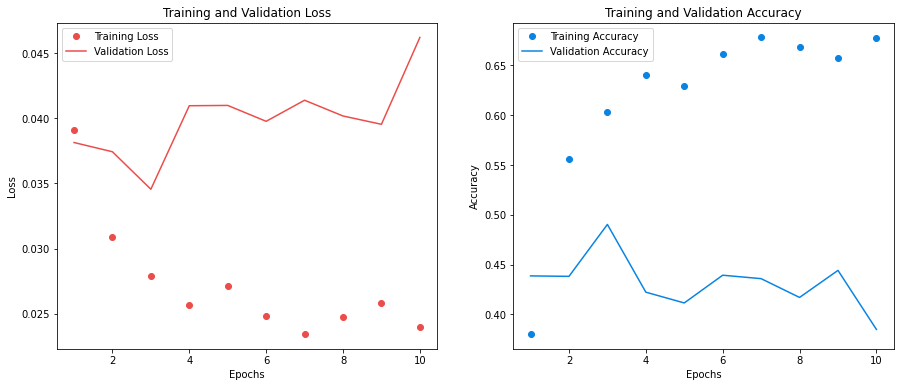

**************************************************************************************************************************************
*******************************************************Validation Subject = 103*******************************************************


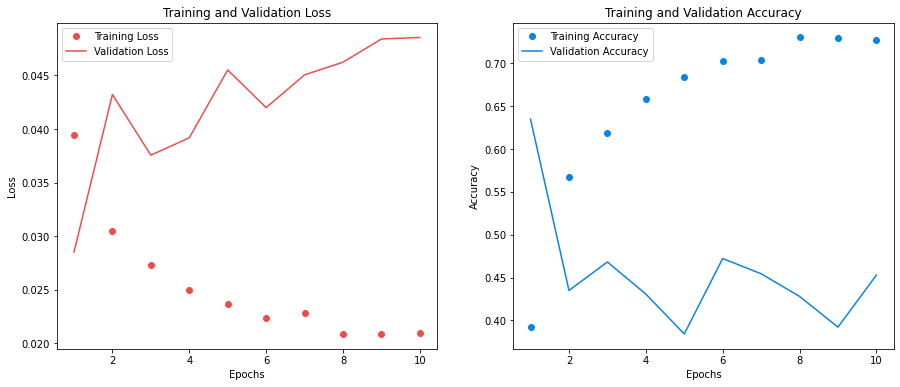

**************************************************************************************************************************************
*******************************************************Validation Subject = 104*******************************************************


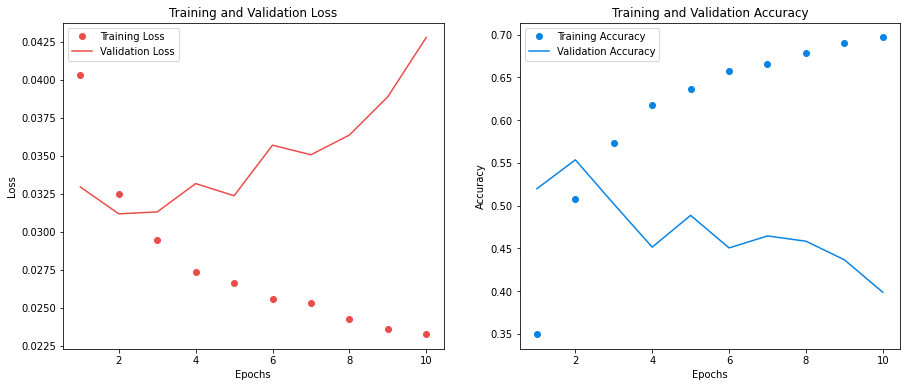

**************************************************************************************************************************************
*******************************************************Validation Subject = 105*******************************************************


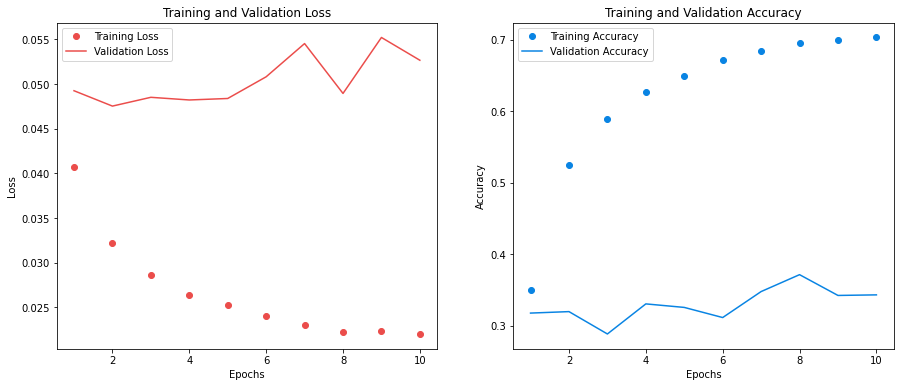

**************************************************************************************************************************************
*******************************************************Validation Subject = 106*******************************************************


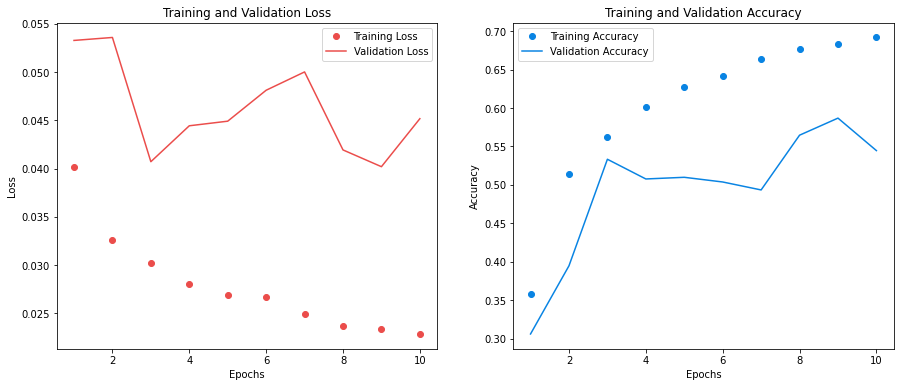

**************************************************************************************************************************************


In [ ]:
for i in range(len(results)):
  history = results[i]
  print('*******************************************************Validation Subject = {}*******************************************************'.format(validationSubjects[i]))
  plot_model(history)
  print('**************************************************************************************************************************************')

Summary of the best results of each fold- 

In [ ]:
listRes = []
for i in range(len(results)):
  res = results[i]
  copy = dict(res.history)
  metrics = copy.keys()
  for metric in metrics:
    if metric == 'loss' or metric =='val_loss':
      copy[metric] = np.min(copy[metric])
    else:
      copy[metric] = np.max(copy[metric])
  copy['ValidationSubject'] = validationSubjects[i]
  listRes = listRes +[copy]
maxTable = pd.DataFrame(listRes)
maxTable.set_index('ValidationSubject',inplace=True)
maxTable.loc['mean'] = maxTable.mean()
maxTable

,loss,accuracy,val_loss,val_accuracy
ValidationSubject,,,,
102,0.023433,0.678083,0.034557,0.490395
103,0.020863,0.730318,0.028515,0.634923
104,0.023277,0.696656,0.031177,0.553534
105,0.022034,0.703138,0.047537,0.371607
106,0.022862,0.691737,0.040196,0.586806
mean,0.022494,0.699986,0.036396,0.527453


As we can see from the above plots and table - our model is overfitted to the train records, an issue we will address later. <br>
We will use the best validation loss weights to preform prediction on the test records -  

In [ ]:
minLossIndex = vloss.index(min(vloss))
subject = validationSubjects[minLossIndex]
print('Validation Subject = {}'.format(subject))
mean = foldMeans[minLossIndex]
std = foldStds[minLossIndex]
x_test = []
y_test = [] 
testMatrices = []
testSubjects = ['107','108']
testData = interpulatedData[interpulatedData['subject'].isin(testSubjects)].copy()
cols = list(interpulatedData.columns)
cols.remove('activity_ID')
cols.remove('subject')
cols.remove('set')
for c in range(len(cols)):
  column = cols[c]
  testData[column] = (testData[column] - mean[c])/std[c]
  testData[column] = testData[column].astype(np.float16)
  gc.collect()
for testSubject in testSubjects:
  print('Test Subject = {}'.format(testSubject))
  for curSet in ['Protocol','Optional']:
    temp = (testData[(testData['subject'] == testSubject) & (testData['set'] == curSet)]).copy()
    if(~temp.empty):
      temp.drop('subject',axis=1, inplace = True)
      temp.drop('set',axis=1, inplace = True)
      bins = create_activity_bins(temp)
      del temp;
      gc.collect()
    for bin in bins:
      if ~bin.empty and bin.shape[0] >= look_back:
        matrices = break_to_lookback_matrices(bin,look_back,jump)
        testMatrices = testMatrices + matrices
        del matrices;
        del bin;
        gc.collect()            
    del bins;
    gc.collect()
for testMatrix in testMatrices:
  testMatrix.reset_index(drop=True, inplace=True)
  y_test.append(testMatrix['activity_ID'].iloc[0])
  testMatrix.drop('activity_ID',axis=1, inplace = True)
  x_test.append(testMatrix.values)
x_test = np.array(x_test)
y_test = np.array(y_test)
model = LSTM_Model(look_back,len(cols),len(activities))
model.load_weights('LSTM_Best_val{}.h5'.format(subject))
predicts = model.predict(x_test)
preds_classes = np.argmax(predicts,axis=1)
predict = np.unique(preds_classes).tolist() 
class_map = list(zip(predict,activities))
class_map = dict(class_map)
res = [class_map[x] for x in preds_classes]

Validation Subject = 104
Test Subject = 107
Test Subject = 108


In [ ]:
print('Fold Validation Subject Weights = {}'.format(subject))
print('LSTM Model Accuracy On Test Set : {}%'.format(round(accuracy_score(y_test,res)*100,5)))

Fold Validation Subject Weights = 104
LSTM Model Accuracy On Test Set : 38.77923%


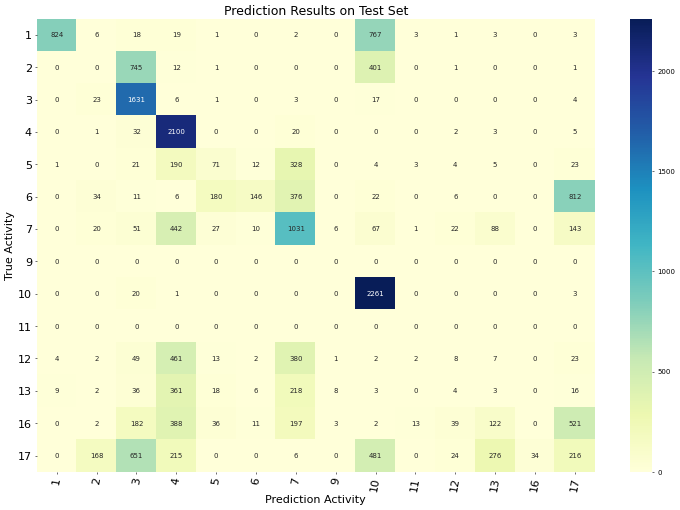

In [ ]:
fig , ax = plt.subplots(figsize=(18,12),dpi=50)
sns.heatmap(confusion_matrix(y_test,res,np.unique(res)),ax=ax,cmap='YlGnBu',annot=True, fmt='g')
label_font = {'size':'16'} 
ax.set_xlabel('Prediction Activity', fontdict=label_font);
ax.set_ylabel('True Activity', fontdict=label_font);

title_font = {'size':'18'}
ax.set_title('Prediction Results on Test Set', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=16) 
ax.set_xticklabels(np.unique(res))
ax.set_yticklabels(np.unique(res))
plt.xticks(rotation=80)
plt.yticks(rotation=0)
plt.show()

We can see that the model often misclassify activities to be one of those we have most records of - 4,10,17.

###e. Pretrain with self-supervised task - 

We chose to implement the first Self-supervised task we suggested. <br>
We will try to predict 3 future ankle_acc_16_y values using look-back of 10 & horizon of 2.

In [ ]:
look_back = 10
pred_steps = 3

In [ ]:
def create_data(x,look_back,pred_steps,horizon):
    df = pd.DataFrame(data=x,columns=['target'])
    for i in range(look_back):
        df['lag{}'.format(i)] = df['target'].shift(i+1)
    for i in range(1,pred_steps+1):
        df['target_{}'.format(-i)] = df['target'].shift(-horizon-i)
    df.drop('target',axis=1,inplace=True)
    df.dropna(inplace=True)
    targets = df.iloc[:,-pred_steps:]
    features = df.iloc[:,:-pred_steps]
    return features,targets

Validation folds -

In [ ]:
col = 'ankle_acc_16_y'
vPreAccs = [] 
vPreLoss = []
preResults = []
foldMeans = []
foldStds = [] 
preds = []
vts = []
for vSubject in validationSubjects:
    print('Validation Subject = {}'.format(vSubject))
    trainFeatures = pd.DataFrame()
    trainTargets = pd.DataFrame()
    valFeatures = pd.DataFrame()
    valTargets = pd.DataFrame()
    gc.collect()
    trainSubjects = ['101','102','103','104','105','106','109']
    trainSubjects.remove(vSubject)
    trainData = interpulatedData[interpulatedData['subject'].isin(trainSubjects)].copy()
    trainData = trainData[[col,'subject','set','activity_ID']].copy()
    validationData = interpulatedData[interpulatedData['subject'] == vSubject].copy()
    validationData = validationData[[col,'subject','set','activity_ID']].copy()
    mean = np.mean(trainData[col])
    foldMeans.append(mean)
    std = np.std(trainData[col])
    foldStds.append(std)
    trainData[col] = (trainData[col] - mean)/std
    trainData[col] = trainData[col].astype(np.float16)
    validationData[col] = (validationData[col] - mean)/std
    validationData[col] = validationData[col].astype(np.float16)
    gc.collect()
    for trainSubject in trainSubjects:
      for curSet in ['Protocol','Optional']:
        temp = (trainData[(trainData['subject'] == trainSubject) & (trainData['set'] == curSet)]).copy()
        if(~temp.empty):
            temp.drop('subject',axis=1, inplace = True)
            temp.drop('set',axis=1, inplace = True)
            bins = create_activity_bins(temp)
            del temp;
            gc.collect()
            for bin in bins:
              if ~bin.empty and bin.shape[0] >= look_back:
                  bin.drop('activity_ID',axis=1, inplace = True)
                  features,targets = create_data(bin.values,look_back,pred_steps,2)
                  trainFeatures = trainFeatures.append(features) 
                  trainTargets = trainTargets.append(targets) 
                  del features;
                  del targets;
                  gc.collect()            
            del bins;
            gc.collect()
    for curSet in ['Protocol','Optional']:
      temp = (validationData[(validationData['subject'] == vSubject) & (validationData['set'] == curSet)]).copy()
      if(~temp.empty):
          temp.drop('subject',axis=1, inplace = True)
          temp.drop('set',axis=1, inplace = True)
          bins = create_activity_bins(temp)
          for bin in bins:
              if ~bin.empty and bin.shape[0] >= look_back:
                  bin.drop('activity_ID',axis=1, inplace = True)
                  features,targets = create_data(bin.values,look_back,pred_steps,2)
                  valFeatures = valFeatures.append(features) 
                  valTargets = valTargets.append(targets)
                  del features;
                  del targets;
                  gc.collect()  
          del bins;
          gc.collect()
    
    print('model')
    model = LSTM_Model(look_back,1,pred_steps,activation = 'noSoft')
    model.layers[1].trainable = False
    model.layers[-1].trainable = False
    checkpoint = ModelCheckpoint('LSTM_pre_Best_loss{}.h5'.format(vSubject), save_best_only=True)
    print(model.summary())
    history = model.fit(np.expand_dims(trainFeatures,axis=-1),trainTargets.values,validation_data=(np.expand_dims(valFeatures,axis=-1),valTargets.values),epochs=5, callbacks=[checkpoint])
    preResults.append(history)
    pred = model.predict(np.stack([valFeatures],axis=-1))
    preds.append(pred)
    vts.append(valTargets)
    del trainFeatures;
    del trainTargets;
    del valFeatures;
    gc.collect()

Validation Subject = 102
model
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 10, 1)]           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_54 (Dense)             (None, 16)                176       
_________________________________________________________________
dropout_36 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_37 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_56 (Dense)           

*******************************************************Validation Subject = 102*******************************************************


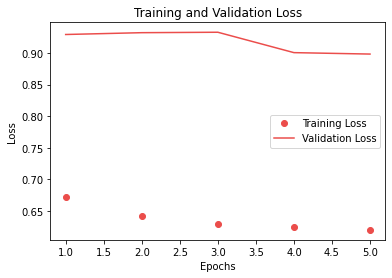

**************************************************************************************************************************************
*******************************************************Validation Subject = 103*******************************************************


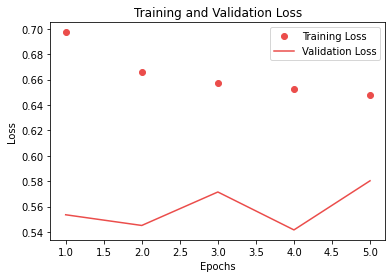

**************************************************************************************************************************************
*******************************************************Validation Subject = 104*******************************************************


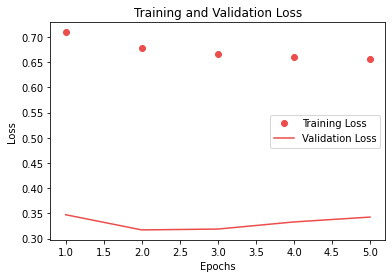

**************************************************************************************************************************************
*******************************************************Validation Subject = 105*******************************************************


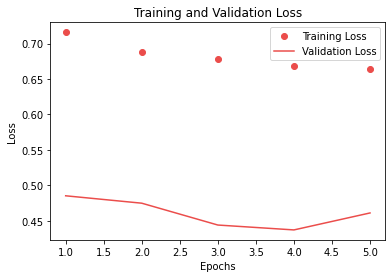

**************************************************************************************************************************************
*******************************************************Validation Subject = 106*******************************************************


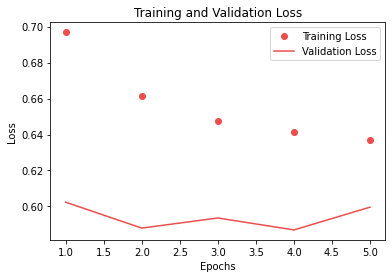

**************************************************************************************************************************************


In [ ]:
for i in range(len(preResults)):
  history = preResults[i]
  print('*******************************************************Validation Subject = {}*******************************************************'.format(validationSubjects[i]))
  plot_model(history)
  print('**************************************************************************************************************************************')

In [ ]:
listRes = []
for i in range(len(preResults)):
  res = preResults[i]
  copy = dict(res.history)
  metrics = copy.keys()
  for metric in metrics:
    copy[metric] = np.min(copy[metric])
  copy['ValidationSubject'] = validationSubjects[i]
  listRes = listRes +[copy]
maxTable = pd.DataFrame(listRes)
maxTable.set_index('ValidationSubject',inplace=True)
maxTable.loc['mean'] = maxTable.mean()
maxTable

,loss,val_loss
ValidationSubject,,
102,0.620132,0.898339
103,0.647553,0.541611
104,0.656185,0.317095
105,0.664809,0.436992
106,0.636989,0.586969
mean,0.645134,0.556201


We can compare our best model's predicts to the actual values -

In [ ]:
minLossIndex = 2
subject = validationSubjects[minLossIndex]
pred = preds[minLossIndex]
valTargets = vts[minLossIndex]

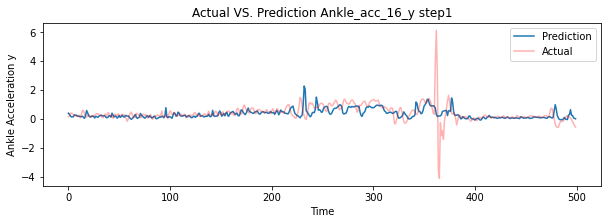

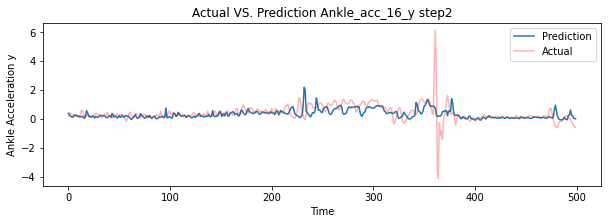

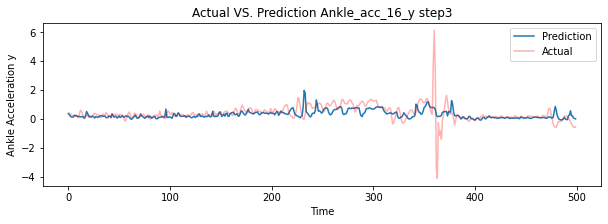

In [ ]:
for i in range(pred_steps):
  plt.figure(figsize=(10, 3));
  plt.plot(pred[-1000:-500,i], label='Prediction' )
  plt.plot(valTargets.iloc[-1000:-500,i].values,c='red',alpha=0.3,  label='Actual')
  plt.legend(loc='best')
  plt.title('Actual VS. Prediction Ankle_acc_16_y step{}'.format(i+1))
  plt.xlabel('Time')
  plt.ylabel('Ankle Acceleration y')
  plt.show()

The model is pretty close to the actual values, but having trouble predicting the peakדץ

We will use the weights from the fold with the lowest loss to pretrain our model -

In [ ]:
bestWeights = 'LSTM_pre_Best_loss104.h5'

In [ ]:
look_back = 200
jump=30

In [ ]:
vaccs = [] 
vloss = []
results = []
foldMeans = []
foldStds = [] 
for vSubject in validationSubjects:
    foldMean = []
    foldStd = []
    print('Fold validation subject = {}'.format(vSubject))
    x_train = []
    y_train = []
    x_val = []
    y_val = [] 
    trainMatrices = []
    valMatrices = []
    gc.collect()
    trainSubjects = ['101','102','103','104','105','106','109']
    trainSubjects.remove(vSubject)
    trainData = interpulatedData[interpulatedData['subject'].isin(trainSubjects)].copy()
    validationData = interpulatedData[interpulatedData['subject'] == vSubject].copy()
    cols = list(interpulatedData.columns)
    cols.remove('activity_ID')
    cols.remove('subject')
    cols.remove('set')
    for column in cols:
      mean = np.mean(trainData[column])
      foldMean.append(mean)
      std = np.std(trainData[column])
      foldStd.append(std)
      trainData[column] = (trainData[column] - mean)/std
      trainData[column] = trainData[column].astype(np.float16)
      validationData[column] = (validationData[column] - mean)/std
      validationData[column] = validationData[column].astype(np.float16)
      gc.collect()
    foldMeans.append(foldMean)
    foldStds.append(foldStd)
    for trainSubject in trainSubjects:
      for curSet in ['Protocol','Optional']:
        temp = (trainData[(trainData['subject'] == trainSubject) & (trainData['set'] == curSet)]).copy()
        if (~temp.empty):
            temp.drop('subject',axis=1, inplace = True)
            temp.drop('set',axis=1, inplace = True)
            bins = create_activity_bins(temp)
            del temp;
            gc.collect()
            for bin in bins:
                if ~bin.empty and bin.shape[0] >= look_back:
                    matrices = break_to_lookback_matrices(bin,look_back,jump)
                    trainMatrices = trainMatrices + matrices
                    del matrices;
                    del bin;
                    gc.collect()            
            del bins;
            gc.collect()
    for curSet in ['Protocol','Optional']:
      temp = (validationData[(validationData['subject'] == vSubject) & (validationData['set'] == curSet)]).copy()
      if (~temp.empty):
          temp.drop('subject',axis=1, inplace = True)
          temp.drop('set',axis=1, inplace = True)
          bins = create_activity_bins(temp)
          for bin in bins:
              if ~bin.empty and bin.shape[0] >= look_back:
                  matrices = break_to_lookback_matrices(bin,look_back,jump)
                  valMatrices = valMatrices + matrices  
          del bins;
          gc.collect()
    for trainMatrix in trainMatrices:
        trainMatrix.reset_index(drop=True, inplace=True)
        y_train.append(trainMatrix['activity_ID'].iloc[0])
        trainMatrix.drop('activity_ID',axis=1, inplace = True)
        x_train.append(trainMatrix.values)
    for valMatrix in valMatrices:
        valMatrix.reset_index(drop=True, inplace=True)
        y_val.append(valMatrix['activity_ID'].iloc[0])
        valMatrix.drop('activity_ID',axis=1, inplace = True)
        x_val.append(valMatrix.values)
    x_train = np.array(x_train)
    activities = list(set(y_train))
    y_train = np.array(y_train)
    x_val = np.array(x_val)
    y_val = np.array(y_val) 
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    fit = y_train.reshape(-1, 1)
    encoder.fit(y_train.reshape(-1, 1))
    y_train = encoder.transform(y_train.reshape(-1, 1))
    y_val = encoder.transform(y_val.reshape(-1, 1))
    model = LSTM_Model(look_back,1,pred_steps,activation = 'relu')
    model.load_weights(bestWeights)
    input =  Input(shape=(look_back,len(cols)))
    x = LSTM(10)(input)
    for i in range(2,len(model.layers)-1):
      x = model.layers[i](x)
    x = Dense(len(activities),activation='softmax')(x)
    model = Model(input,x)
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])    
    checkpoint = ModelCheckpoint('LSTM_Best_val_after_pre{}.h5'.format(vSubject),monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
    print(model.summary())
    history = model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=10, callbacks=[checkpoint])
    results.append(history)
    ev = model.evaluate(x=x_val,y=y_val)
    ev = dict(zip(model.metrics_names,ev))
    vaccs.append(ev['accuracy'])
    vloss.append(ev['loss'])
    print('**************************************************************************************************************************************')
    del x_train;
    del y_train;
    del x_val;
    del y_val;
    del trainMatrices;
    del valMatrices;
    del trainData;
    del validationData;
    gc.collect()

Fold validation subject = 102
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 200, 40)]         0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 10)                2040      
_________________________________________________________________
dense_69 (Dense)             (None, 16)                176       
_________________________________________________________________
dropout_46 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_47 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_72 (Dense)            

*******************************************************Validation Subject = 102*******************************************************


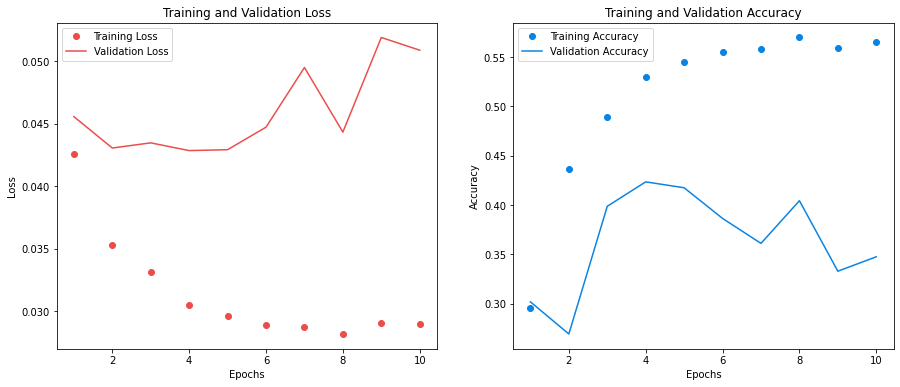

**************************************************************************************************************************************
*******************************************************Validation Subject = 103*******************************************************


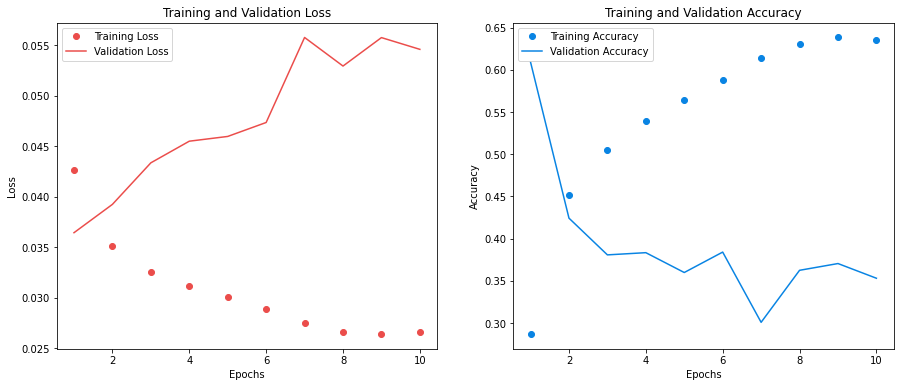

**************************************************************************************************************************************
*******************************************************Validation Subject = 104*******************************************************


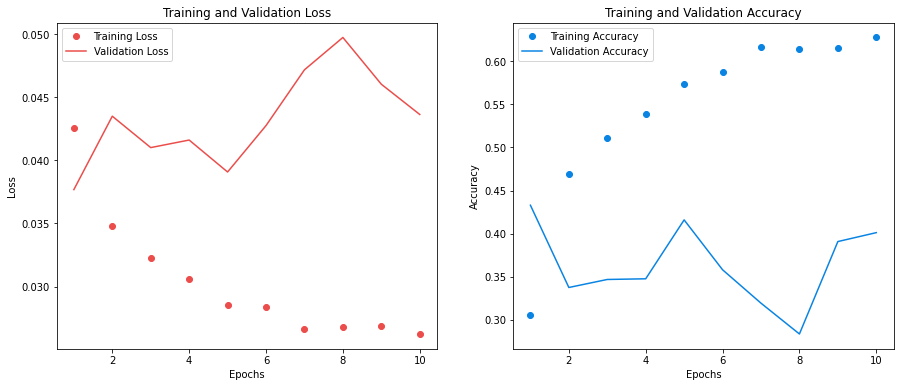

**************************************************************************************************************************************
*******************************************************Validation Subject = 105*******************************************************


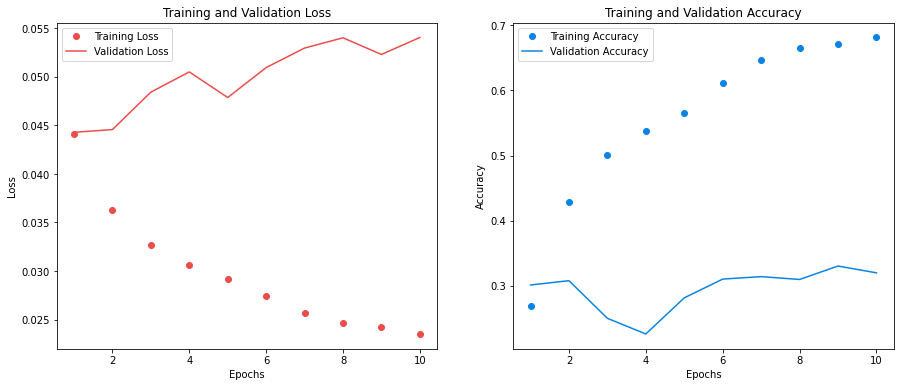

**************************************************************************************************************************************
*******************************************************Validation Subject = 106*******************************************************


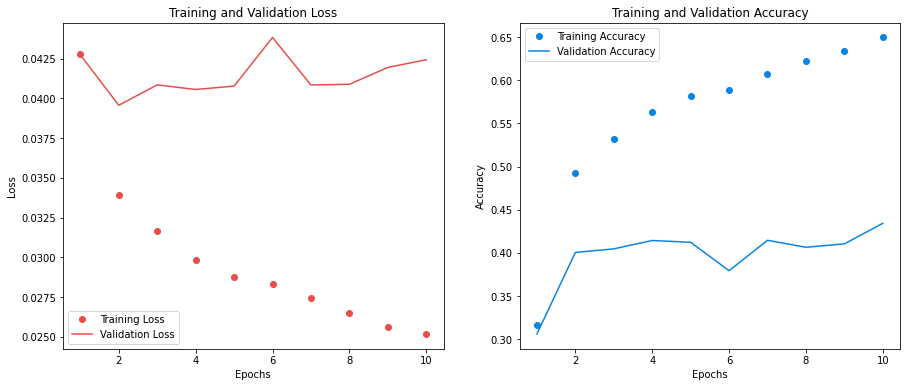

**************************************************************************************************************************************


In [ ]:
for i in range(len(results)):
  history = results[i]
  print('*******************************************************Validation Subject = {}*******************************************************'.format(validationSubjects[i]))
  plot_model(history)
  print('**************************************************************************************************************************************')

In [ ]:
listRes = []
for i in range(len(results)):
  res = results[i]
  copy = dict(res.history)
  metrics = copy.keys()
  for metric in metrics:
    if metric == 'loss' or metric =='val_loss':
      copy[metric] = np.min(copy[metric])
    else:
      copy[metric] = np.max(copy[metric])
  copy['ValidationSubject'] = validationSubjects[i]
  listRes = listRes +[copy]
maxTable = pd.DataFrame(listRes)
maxTable.set_index('ValidationSubject',inplace=True)
maxTable.loc['mean'] = maxTable.mean()
maxTable

,loss,accuracy,val_loss,val_accuracy
ValidationSubject,,,,
102,0.028185,0.569772,0.042854,0.423444
103,0.026408,0.638344,0.036433,0.609157
104,0.026241,0.627571,0.037677,0.432984
105,0.023511,0.681019,0.044292,0.330521
106,0.025172,0.649601,0.039569,0.434238
mean,0.025904,0.633261,0.040165,0.446069


In [ ]:
minLossIndex = vloss.index(min(vloss))
subject = validationSubjects[minLossIndex]
print('Validation Subject = {}'.format(subject))
mean = foldMeans[minLossIndex]
std = foldStds[minLossIndex]
x_test = []
y_test = [] 
testMatrices = []
testSubjects = ['107','108']
testData = interpulatedData[interpulatedData['subject'].isin(testSubjects)].copy()
cols = list(interpulatedData.columns)
cols.remove('activity_ID')
cols.remove('subject')
cols.remove('set')
for c in range(len(cols)):
  column = cols[c]
  testData[column] = (testData[column] - mean[c])/std[c]
  testData[column] = testData[column].astype(np.float16)
  gc.collect()
for testSubject in testSubjects:
  print('Test Subject = {}'.format(testSubject))
  for curSet in ['Protocol','Optional']:
    temp = (testData[(testData['subject'] == testSubject) & (testData['set'] == curSet)]).copy()
    if(~temp.empty):
      temp.drop('subject',axis=1, inplace = True)
      temp.drop('set',axis=1, inplace = True)
      bins = create_activity_bins(temp)
      del temp;
      gc.collect()
    for bin in bins:
      if ~bin.empty and bin.shape[0] >= look_back:
        matrices = break_to_lookback_matrices(bin,look_back,jump)
        testMatrices = testMatrices + matrices
        del matrices;
        del bin;
        gc.collect()            
    del bins;
    gc.collect()
for testMatrix in testMatrices:
  testMatrix.reset_index(drop=True, inplace=True)
  y_test.append(testMatrix['activity_ID'].iloc[0])
  testMatrix.drop('activity_ID',axis=1, inplace = True)
  x_test.append(testMatrix.values)
x_test = np.array(x_test)
y_test = np.array(y_test)
model = LSTM_Model(look_back,len(cols),len(activities))
model.load_weights('LSTM_Best_val_after_pre{}.h5'.format(subject))
predicts = model.predict(x_test)
preds_classes = np.argmax(predicts,axis=1)
predict = np.unique(preds_classes).tolist() 
class_map = list(zip(predict,activities))
class_map = dict(class_map)
res = [class_map[x] for x in preds_classes]

Validation Subject = 106
Test Subject = 107
Test Subject = 108


In [ ]:
print('Fold Validation Subject Weights = {}'.format(subject))
print('LSTM Model Accuracy On Test Set : {}%'.format(round(accuracy_score(y_test,res)*100,5)))

Fold Validation Subject Weights = 106
LSTM Model Accuracy On Test Set : 20.64079%


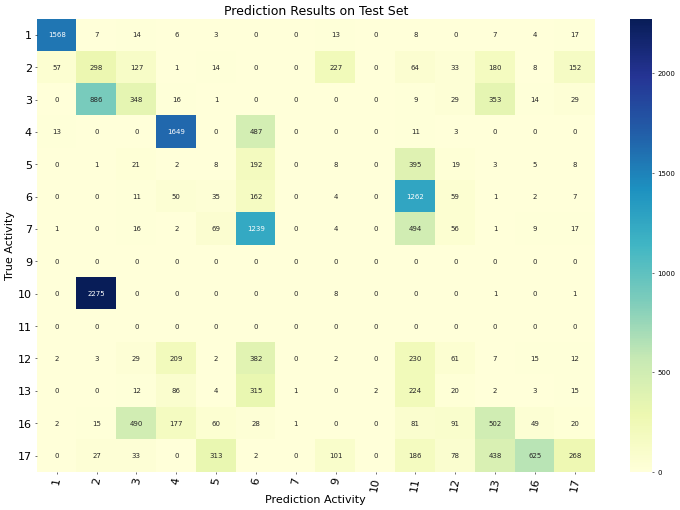

In [ ]:
fig , ax = plt.subplots(figsize=(18,12),dpi=50)
sns.heatmap(confusion_matrix(y_test,res,np.unique(res)),ax=ax,cmap='YlGnBu',annot=True, fmt='g')
label_font = {'size':'16'} 
ax.set_xlabel('Prediction Activity', fontdict=label_font);
ax.set_ylabel('True Activity', fontdict=label_font);

title_font = {'size':'18'}
ax.set_title('Prediction Results on Test Set', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=16) 
ax.set_xticklabels(np.unique(res))
ax.set_yticklabels(np.unique(res))
plt.xticks(rotation=80)
plt.yticks(rotation=0)
plt.show()

As we can see the pre-train resulted much lower accuracy. Looking at the confusion matrix we can see that the model never chose activity 10 (which is the most common), and almost always missclassifing it as activity 2.

###f. Improvement ideas -

As we can see on our cross-validation results, we get better results on our train set compare to our validation set, indicating our model is overfitted to the train data, but complex enough to adress the problem. <br>
We will suggest three different aproches to handle this issue - 
1. Decrease model complexity
2. Increase dropout
3. Early stopping


###g. Improvements implementation -


We decided to implement the first two ideas. <br> 
Comparing to both of them, we assume early stopping won't be so helpful because we preform only 5 folds, 10 epches each.

1. Decrease model complexity <br>
We will reduce the number of LSTM layers from 10 to 5. <br><br>
Validation folds - 

In [88]:
vaccs = [] 
vloss = []
results = []
foldMeans = []
foldStds = [] 
for vSubject in validationSubjects:
    foldMean = []
    foldStd = []
    print('Fold validation subject = {}'.format(vSubject))
    x_train = []
    y_train = []
    x_val = []
    y_val = [] 
    trainMatrices = []
    valMatrices = []
    gc.collect()
    trainSubjects = ['101','102','103','104','105','106','109']
    trainSubjects.remove(vSubject)
    trainData = interpulatedData[interpulatedData['subject'].isin(trainSubjects)].copy()
    validationData = interpulatedData[interpulatedData['subject'] == vSubject].copy()
    cols = list(interpulatedData.columns)
    cols.remove('activity_ID')
    cols.remove('subject')
    cols.remove('set')
    for column in cols:
      mean = np.mean(trainData[column])
      foldMean.append(mean)
      std = np.std(trainData[column])
      foldStd.append(std)
      trainData[column] = (trainData[column] - mean)/std
      trainData[column] = trainData[column].astype(np.float16)
      validationData[column] = (validationData[column] - mean)/std
      validationData[column] = validationData[column].astype(np.float16)
      gc.collect()
    foldMeans.append(foldMean)
    foldStds.append(foldStd)
    for trainSubject in trainSubjects:
      for curSet in ['Protocol','Optional']:
        temp = (trainData[(trainData['subject'] == trainSubject) & (trainData['set'] == curSet)]).copy()
        if (~temp.empty):
            temp.drop('subject',axis=1, inplace = True)
            temp.drop('set',axis=1, inplace = True)
            bins = create_activity_bins(temp)
            del temp;
            gc.collect()
            for bin in bins:
                if ~bin.empty and bin.shape[0] >= look_back:
                    matrices = break_to_lookback_matrices(bin,look_back,jump)
                    trainMatrices = trainMatrices + matrices
                    del matrices;
                    del bin;
                    gc.collect()            
            del bins;
            gc.collect()
    for curSet in ['Protocol','Optional']:
      temp = (validationData[(validationData['subject'] == vSubject) & (validationData['set'] == curSet)]).copy()
      if (~temp.empty):
          temp.drop('subject',axis=1, inplace = True)
          temp.drop('set',axis=1, inplace = True)
          bins = create_activity_bins(temp)
          for bin in bins:
              if ~bin.empty and bin.shape[0] >= look_back:
                  matrices = break_to_lookback_matrices(bin,look_back,jump)
                  valMatrices = valMatrices + matrices  
          del bins;
          gc.collect()
    for trainMatrix in trainMatrices:
        trainMatrix.reset_index(drop=True, inplace=True)
        y_train.append(trainMatrix['activity_ID'].iloc[0])
        trainMatrix.drop('activity_ID',axis=1, inplace = True)
        x_train.append(trainMatrix.values)
    for valMatrix in valMatrices:
        valMatrix.reset_index(drop=True, inplace=True)
        y_val.append(valMatrix['activity_ID'].iloc[0])
        valMatrix.drop('activity_ID',axis=1, inplace = True)
        x_val.append(valMatrix.values)
    x_train = np.array(x_train)
    activities = list(set(y_train))
    y_train = np.array(y_train)
    x_val = np.array(x_val)
    y_val = np.array(y_val) 
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    fit = y_train.reshape(-1, 1)
    encoder.fit(y_train.reshape(-1, 1))
    y_train = encoder.transform(y_train.reshape(-1, 1))
    y_val = encoder.transform(y_val.reshape(-1, 1))
    model = LSTM_Model(look_back,len(cols),len(activities),LstmSize=5)
    checkpoint = ModelCheckpoint('LSTM_Best_val_reduced{}.h5'.format(vSubject),monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
    print(model.summary())
    history = model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=10, callbacks=[checkpoint])
    results.append(history)
    ev = model.evaluate(x=x_val,y=y_val)
    ev = dict(zip(model.metrics_names,ev))
    vaccs.append(ev['accuracy'])
    vloss.append(ev['loss'])
    print('**************************************************************************************************************************************')
    del x_train;
    del y_train;
    del x_val;
    del y_val;
    del trainMatrices;
    del valMatrices;
    del trainData;
    del validationData;
    gc.collect()

Fold validation subject = 102
Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 200, 40)]         0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 5)                 920       
_________________________________________________________________
dense_92 (Dense)             (None, 16)                96        
_________________________________________________________________
dropout_58 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_93 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_59 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_94 (Dense)            

Validation results - 

*******************************************************Validation Subject = 102*******************************************************


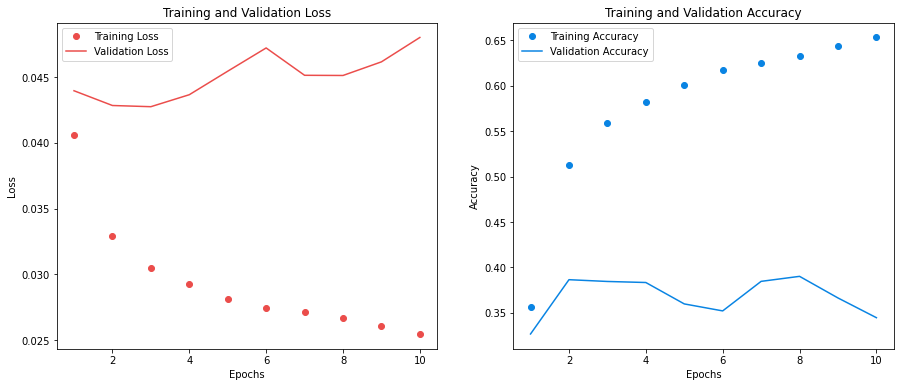

**************************************************************************************************************************************
*******************************************************Validation Subject = 103*******************************************************


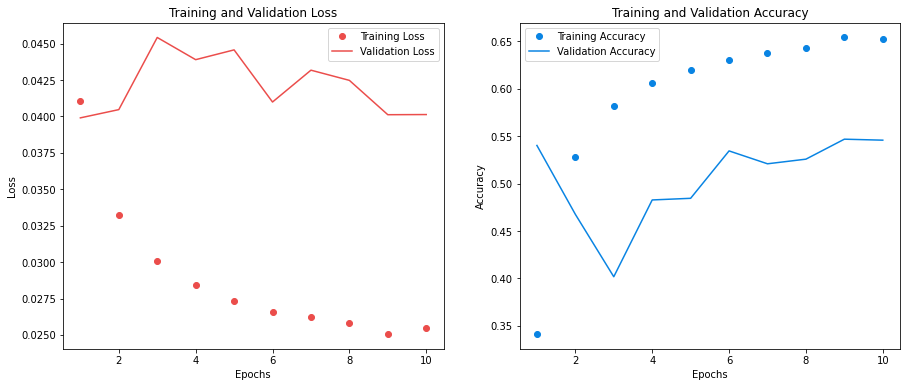

**************************************************************************************************************************************
*******************************************************Validation Subject = 104*******************************************************


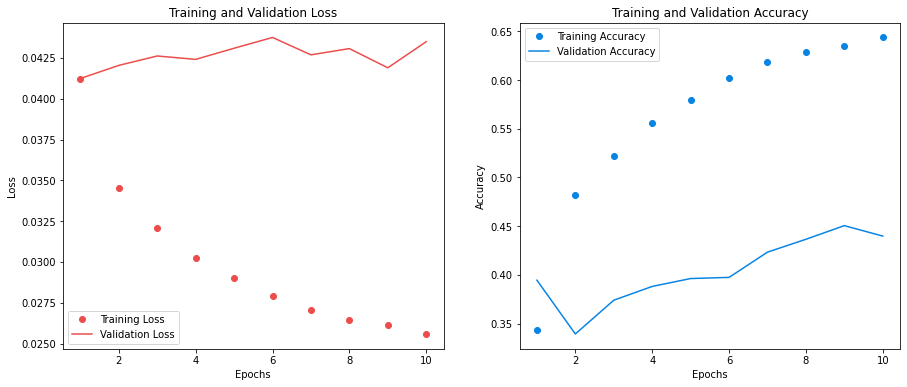

**************************************************************************************************************************************
*******************************************************Validation Subject = 105*******************************************************


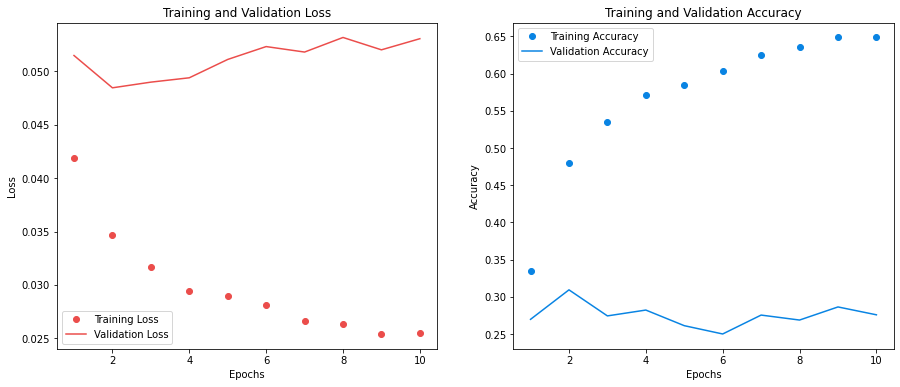

**************************************************************************************************************************************
*******************************************************Validation Subject = 106*******************************************************


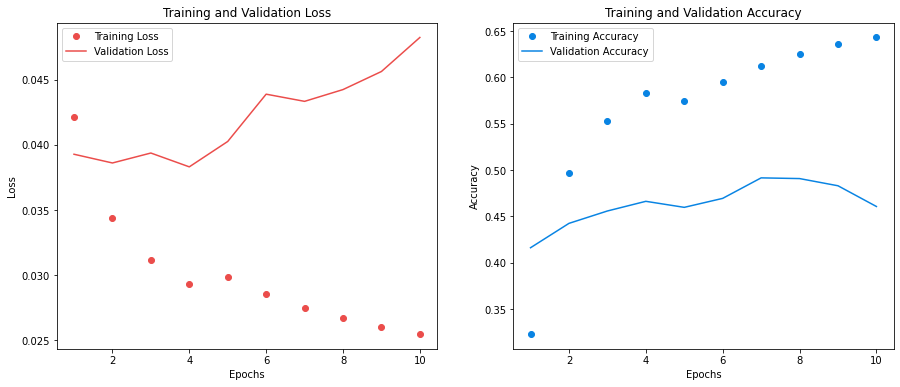

**************************************************************************************************************************************


In [89]:
for i in range(len(results)):
  history = results[i]
  print('*******************************************************Validation Subject = {}*******************************************************'.format(validationSubjects[i]))
  plot_model(history)
  print('**************************************************************************************************************************************')

In [90]:
listRes = []
for i in range(len(results)):
  res = results[i]
  copy = dict(res.history)
  metrics = copy.keys()
  for metric in metrics:
    if metric == 'loss' or metric =='val_loss':
      copy[metric] = np.min(copy[metric])
    else:
      copy[metric] = np.max(copy[metric])
  copy['ValidationSubject'] = validationSubjects[i]
  listRes = listRes +[copy]
maxTable = pd.DataFrame(listRes)
maxTable.set_index('ValidationSubject',inplace=True)
maxTable.loc['mean'] = maxTable.mean()
maxTable

,loss,accuracy,val_loss,val_accuracy
ValidationSubject,,,,
102,0.025477,0.653317,0.042753,0.390084
103,0.025065,0.654070,0.039903,0.546831
104,0.025584,0.643770,0.041238,0.450524
105,0.025398,0.648476,0.048468,0.309391
106,0.025487,0.643166,0.038316,0.491608
mean,0.025402,0.648560,0.042136,0.437688


In [91]:
minLossIndex = vloss.index(min(vloss))
subject = validationSubjects[minLossIndex]
print('Validation Subject = {}'.format(subject))
mean = foldMeans[minLossIndex]
std = foldStds[minLossIndex]
x_test = []
y_test = [] 
testMatrices = []
testSubjects = ['107','108']
testData = interpulatedData[interpulatedData['subject'].isin(testSubjects)].copy()
cols = list(interpulatedData.columns)
cols.remove('activity_ID')
cols.remove('subject')
cols.remove('set')
for c in range(len(cols)):
  column = cols[c]
  testData[column] = (testData[column] - mean[c])/std[c]
  testData[column] = testData[column].astype(np.float16)
  gc.collect()
for testSubject in testSubjects:
  print('Test Subject = {}'.format(testSubject))
  for curSet in ['Protocol','Optional']:
    temp = (testData[(testData['subject'] == testSubject) & (testData['set'] == curSet)]).copy()
    if(~temp.empty):
      temp.drop('subject',axis=1, inplace = True)
      temp.drop('set',axis=1, inplace = True)
      bins = create_activity_bins(temp)
      del temp;
      gc.collect()
    for bin in bins:
      if ~bin.empty and bin.shape[0] >= look_back:
        matrices = break_to_lookback_matrices(bin,look_back,jump)
        testMatrices = testMatrices + matrices
        del matrices;
        del bin;
        gc.collect()            
    del bins;
    gc.collect()
for testMatrix in testMatrices:
  testMatrix.reset_index(drop=True, inplace=True)
  y_test.append(testMatrix['activity_ID'].iloc[0])
  testMatrix.drop('activity_ID',axis=1, inplace = True)
  x_test.append(testMatrix.values)
x_test = np.array(x_test)
y_test = np.array(y_test)
model = LSTM_Model(look_back,len(cols),len(activities),LstmSize=5)
model.load_weights('LSTM_Best_val_reduced{}.h5'.format(subject))
predicts = model.predict(x_test)
preds_classes = np.argmax(predicts,axis=1)
predict = np.unique(preds_classes).tolist() 
class_map = list(zip(predict,activities))
class_map = dict(class_map)
res = [class_map[x] for x in preds_classes]

Validation Subject = 103
Test Subject = 107
Test Subject = 108


In [92]:
print('Fold Validation Subject Weights = {}'.format(subject))
print('LSTM Model Accuracy On Test Set : {}%'.format(round(accuracy_score(y_test,res)*100,5)))

Fold Validation Subject Weights = 103
LSTM Model Accuracy On Test Set : 45.93078%


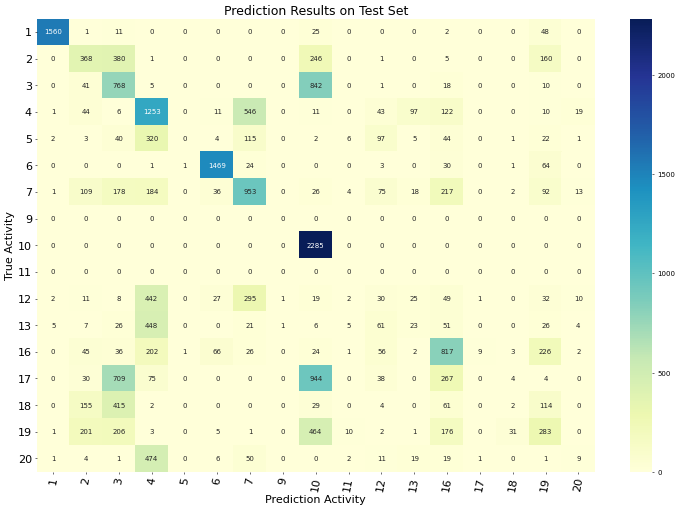

In [93]:
fig , ax = plt.subplots(figsize=(18,12),dpi=50)
sns.heatmap(confusion_matrix(y_test,res,np.unique(res)),ax=ax,cmap='YlGnBu',annot=True, fmt='g')
label_font = {'size':'16'} 
ax.set_xlabel('Prediction Activity', fontdict=label_font);
ax.set_ylabel('True Activity', fontdict=label_font);

title_font = {'size':'18'}
ax.set_title('Prediction Results on Test Set', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=16) 
ax.set_xticklabels(np.unique(res))
ax.set_yticklabels(np.unique(res))
plt.xticks(rotation=80)
plt.yticks(rotation=0)
plt.show()

We can see that the model is still overfitting, but we did got better results on the test data then before. 

2. Increase dropout <br>
We will increase the first dropout from 0.32 to 0.5 and the second from 0.64 to 0.75. <br><br>
Validation folds - 

In [21]:
vaccs = [] 
vloss = []
results = []
foldMeans = []
foldStds = [] 
for vSubject in validationSubjects:
    foldMean = []
    foldStd = []
    print('Fold validation subject = {}'.format(vSubject))
    x_train = []
    y_train = []
    x_val = []
    y_val = [] 
    trainMatrices = []
    valMatrices = []
    gc.collect()
    trainSubjects = ['101','102','103','104','105','106','109']
    trainSubjects.remove(vSubject)
    trainData = interpulatedData[interpulatedData['subject'].isin(trainSubjects)].copy()
    validationData = interpulatedData[interpulatedData['subject'] == vSubject].copy()
    cols = list(interpulatedData.columns)
    cols.remove('activity_ID')
    cols.remove('subject')
    cols.remove('set')
    for column in cols:
      mean = np.mean(trainData[column])
      foldMean.append(mean)
      std = np.std(trainData[column])
      foldStd.append(std)
      trainData[column] = (trainData[column] - mean)/std
      trainData[column] = trainData[column].astype(np.float16)
      validationData[column] = (validationData[column] - mean)/std
      validationData[column] = validationData[column].astype(np.float16)
      gc.collect()
    foldMeans.append(foldMean)
    foldStds.append(foldStd)
    for trainSubject in trainSubjects:
      for curSet in ['Protocol','Optional']:
        temp = (trainData[(trainData['subject'] == trainSubject) & (trainData['set'] == curSet)]).copy()
        if (~temp.empty):
            temp.drop('subject',axis=1, inplace = True)
            temp.drop('set',axis=1, inplace = True)
            bins = create_activity_bins(temp)
            del temp;
            gc.collect()
            for bin in bins:
                if ~bin.empty and bin.shape[0] >= look_back:
                    matrices = break_to_lookback_matrices(bin,look_back,jump)
                    trainMatrices = trainMatrices + matrices
                    del matrices;
                    del bin;
                    gc.collect()            
            del bins;
            gc.collect()
    for curSet in ['Protocol','Optional']:
      temp = (validationData[(validationData['subject'] == vSubject) & (validationData['set'] == curSet)]).copy()
      if (~temp.empty):
          temp.drop('subject',axis=1, inplace = True)
          temp.drop('set',axis=1, inplace = True)
          bins = create_activity_bins(temp)
          for bin in bins:
              if ~bin.empty and bin.shape[0] >= look_back:
                  matrices = break_to_lookback_matrices(bin,look_back,jump)
                  valMatrices = valMatrices + matrices  
          del bins;
          gc.collect()
    for trainMatrix in trainMatrices:
        trainMatrix.reset_index(drop=True, inplace=True)
        y_train.append(trainMatrix['activity_ID'].iloc[0])
        trainMatrix.drop('activity_ID',axis=1, inplace = True)
        x_train.append(trainMatrix.values)
    for valMatrix in valMatrices:
        valMatrix.reset_index(drop=True, inplace=True)
        y_val.append(valMatrix['activity_ID'].iloc[0])
        valMatrix.drop('activity_ID',axis=1, inplace = True)
        x_val.append(valMatrix.values)
    x_train = np.array(x_train)
    activities = list(set(y_train))
    y_train = np.array(y_train)
    x_val = np.array(x_val)
    y_val = np.array(y_val) 
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    fit = y_train.reshape(-1, 1)
    encoder.fit(y_train.reshape(-1, 1))
    y_train = encoder.transform(y_train.reshape(-1, 1))
    y_val = encoder.transform(y_val.reshape(-1, 1))
    model = LSTM_Model(look_back,len(cols),len(activities),drop1 = 0.5, drop2 = 0.75)
    checkpoint = ModelCheckpoint('LSTM_Best_val_increased{}.h5'.format(vSubject),monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
    print(model.summary())
    history = model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=10, callbacks=[checkpoint])
    results.append(history)
    ev = model.evaluate(x=x_val,y=y_val)
    ev = dict(zip(model.metrics_names,ev))
    vaccs.append(ev['accuracy'])
    vloss.append(ev['loss'])
    print('**************************************************************************************************************************************')
    del x_train;
    del y_train;
    del x_val;
    del y_val;
    del trainMatrices;
    del valMatrices;
    del trainData;
    del validationData;
    gc.collect()

Fold validation subject = 102
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 40)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                2040      
_________________________________________________________________
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (N

*******************************************************Validation Subject = 102*******************************************************


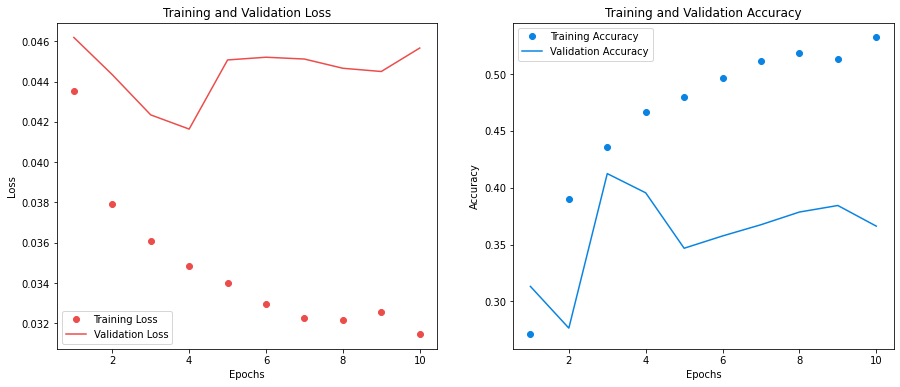

**************************************************************************************************************************************
*******************************************************Validation Subject = 103*******************************************************


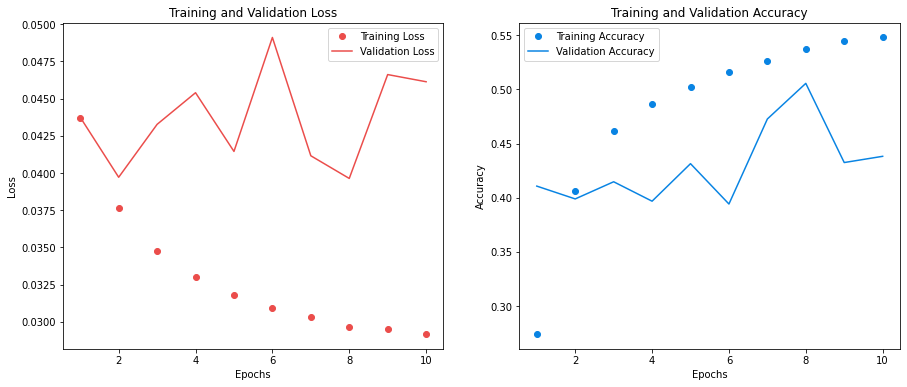

**************************************************************************************************************************************
*******************************************************Validation Subject = 104*******************************************************


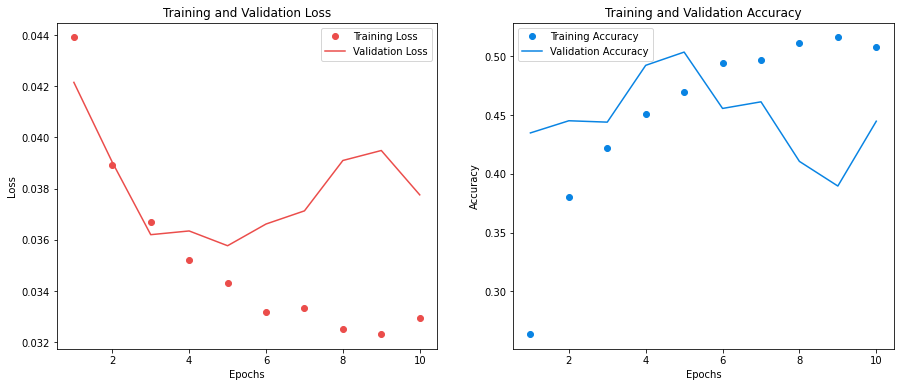

**************************************************************************************************************************************
*******************************************************Validation Subject = 105*******************************************************


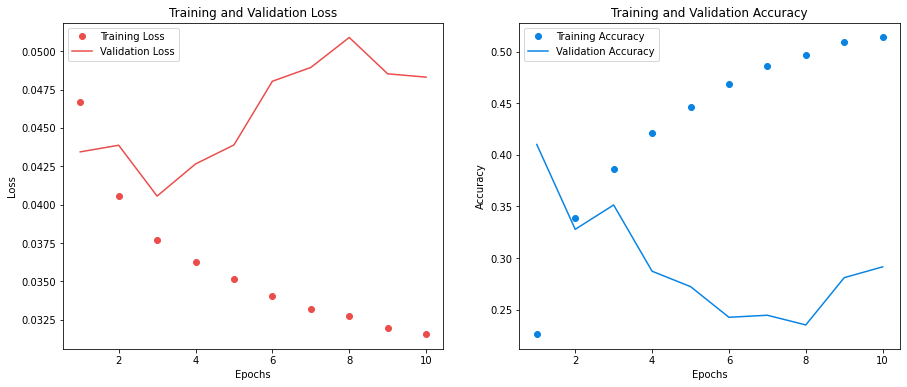

**************************************************************************************************************************************
*******************************************************Validation Subject = 106*******************************************************


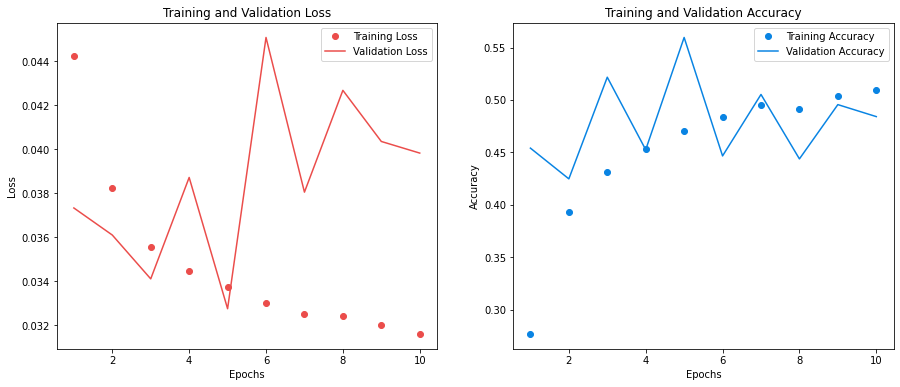

**************************************************************************************************************************************


In [24]:
for i in range(len(results)):
  history = results[i]
  print('*******************************************************Validation Subject = {}*******************************************************'.format(validationSubjects[i]))
  plot_model(history)
  print('**************************************************************************************************************************************')

In [25]:
listRes = []
for i in range(len(results)):
  res = results[i]
  copy = dict(res.history)
  metrics = copy.keys()
  for metric in metrics:
    if metric == 'loss' or metric =='val_loss':
      copy[metric] = np.min(copy[metric])
    else:
      copy[metric] = np.max(copy[metric])
  copy['ValidationSubject'] = validationSubjects[i]
  listRes = listRes +[copy]
maxTable = pd.DataFrame(listRes)
maxTable.set_index('ValidationSubject',inplace=True)
maxTable.loc['mean'] = maxTable.mean()
maxTable

,loss,accuracy,val_loss,val_accuracy
ValidationSubject,,,,
102,0.031467,0.532207,0.041644,0.412401
103,0.029174,0.547957,0.039633,0.505571
104,0.032322,0.515969,0.035770,0.503534
105,0.031577,0.513929,0.040558,0.410125
106,0.031614,0.509829,0.032762,0.559582
mean,0.031231,0.523978,0.038073,0.478243


In [26]:
minLossIndex = vloss.index(min(vloss))
subject = validationSubjects[minLossIndex]
print('Validation Subject = {}'.format(subject))
mean = foldMeans[minLossIndex]
std = foldStds[minLossIndex]
x_test = []
y_test = [] 
testMatrices = []
testSubjects = ['107','108']
testData = interpulatedData[interpulatedData['subject'].isin(testSubjects)].copy()
cols = list(interpulatedData.columns)
cols.remove('activity_ID')
cols.remove('subject')
cols.remove('set')
for c in range(len(cols)):
  column = cols[c]
  testData[column] = (testData[column] - mean[c])/std[c]
  testData[column] = testData[column].astype(np.float16)
  gc.collect()
for testSubject in testSubjects:
  print('Test Subject = {}'.format(testSubject))
  for curSet in ['Protocol','Optional']:
    temp = (testData[(testData['subject'] == testSubject) & (testData['set'] == curSet)]).copy()
    if(~temp.empty):
      temp.drop('subject',axis=1, inplace = True)
      temp.drop('set',axis=1, inplace = True)
      bins = create_activity_bins(temp)
      del temp;
      gc.collect()
    for bin in bins:
      if ~bin.empty and bin.shape[0] >= look_back:
        matrices = break_to_lookback_matrices(bin,look_back,jump)
        testMatrices = testMatrices + matrices
        del matrices;
        del bin;
        gc.collect()            
    del bins;
    gc.collect()
for testMatrix in testMatrices:
  testMatrix.reset_index(drop=True, inplace=True)
  y_test.append(testMatrix['activity_ID'].iloc[0])
  testMatrix.drop('activity_ID',axis=1, inplace = True)
  x_test.append(testMatrix.values)
x_test = np.array(x_test)
y_test = np.array(y_test)
model = LSTM_Model(look_back,len(cols),len(activities),drop1 = 0.5, drop2 = 0.75)
model.load_weights('LSTM_Best_val_increased{}.h5'.format(subject))
predicts = model.predict(x_test)
preds_classes = np.argmax(predicts,axis=1)
predict = np.unique(preds_classes).tolist() 
class_map = list(zip(predict,activities))
class_map = dict(class_map)
res = [class_map[x] for x in preds_classes]

Validation Subject = 104
Test Subject = 107
Test Subject = 108


In [27]:
print('Fold Validation Subject Weights = {}'.format(subject))
print('LSTM Model Accuracy On Test Set : {}%'.format(round(accuracy_score(y_test,res)*100,5)))

Fold Validation Subject Weights = 104
LSTM Model Accuracy On Test Set : 44.36857%


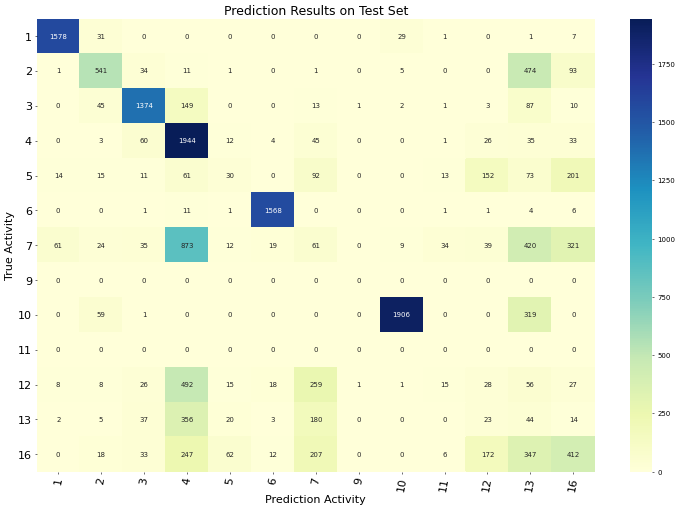

In [28]:
fig , ax = plt.subplots(figsize=(18,12),dpi=50)
sns.heatmap(confusion_matrix(y_test,res,np.unique(res)),ax=ax,cmap='YlGnBu',annot=True, fmt='g')
label_font = {'size':'16'} 
ax.set_xlabel('Prediction Activity', fontdict=label_font);
ax.set_ylabel('True Activity', fontdict=label_font);

title_font = {'size':'18'}
ax.set_title('Prediction Results on Test Set', fontdict=title_font);
ax.tick_params(axis='both', which='major', labelsize=16) 
ax.set_xticklabels(np.unique(res))
ax.set_yticklabels(np.unique(res))
plt.xticks(rotation=80)
plt.yticks(rotation=0)
plt.show()

Again, we can see that the model is still overfitting, but we did got better results on the test data then before. 

Both our implementations got better Test Accuracy and reduced gap between our best train, validation & test results. 

###Result summary

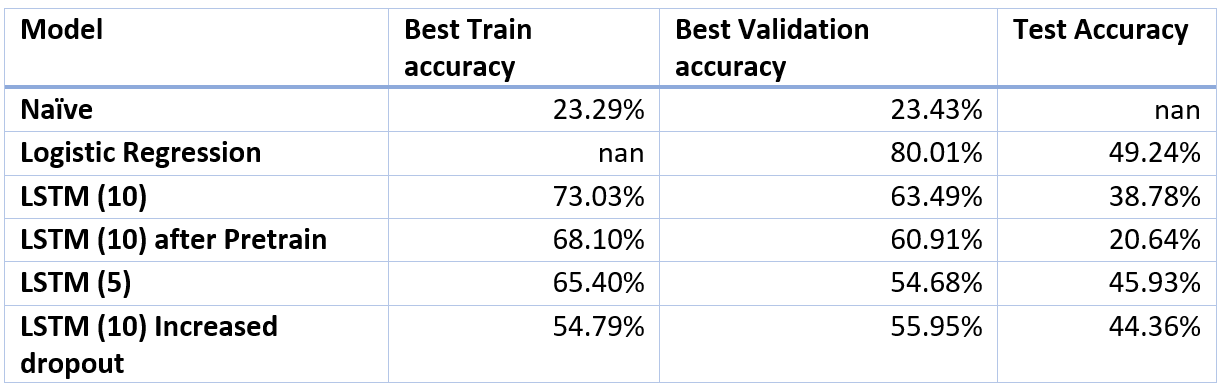